# Honolulu rentals 

In [11]:
# upload necessary libraries

import pandas as pd
import numpy as np
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.feature_selection import f_classif
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import  XGBRegressor
from numpy import arange
from pandas import read_csv
from sklearn.model_selection import RepeatedKFold
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Data Acquisiton

In [12]:
# import necessary libraries
import requests
from bs4 import BeautifulSoup as bs

# specify the parameters of the browser settings
header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.61 Safari/537.36'}

# create a url list to scrape data from all pages
html = requests.get('https://honolulu.craigslist.org/d/apartments-housing-for-rent/search/apa', headers = header)

#check status code, if 200 then continue
html.status_code

200

In [13]:
def get_page(url):
    """
    function to get the page status the the bs object
    """
    page = requests.get(url)
    status = page.status_code
    soup = bs(page.text, 'lxml')
    
    return [soup, status]

url = 'https://honolulu.craigslist.org/d/apartments-housing-for-rent/search/apa'
soup = get_page(url)[0]

In [14]:
def get_links(soup):
    """
    collect the links fron the individual webpages of Craiglist
    """
    list_links = []
    for link in soup.findAll('h3',{'class':'result-heading'}):
        list_links.append(link.a['href'])
    
    return list_links

list_links = get_links(soup)

In [18]:
def extract_info(list_links):
    """
    extract info from the webpages
    """
    get_info = []
    
    # iterate across the saved links 
    for link in list_links:

        res = requests.get(link).text

        soup_ind_link = bs(res, 'lxml')
        
        """
        some issues were observed while extracting the coordinates, 
        thus I must declare a variable corr = [] before the scraping
        """
        coor = []
        
        """
        try except is needed because sometimes the scraper might not find the data
        or the data will have a different format or errors would occur
        """
        try:
            area = soup_ind_link.find('span',{'class':'housing'}).text.strip()
            description = soup_ind_link.find('span',{'id':'titletextonly'}).text.strip()
            price = soup_ind_link.find('span',{'class':'price'}).text.strip()
            adress = soup_ind_link.find('span',{'class':'postingtitletext'}).small.text.strip()
            info = soup_ind_link.find('section',{'id':'postingbody'}).text.strip()
            post_date = soup_ind_link.find('div',{'class':'reply-button-row'}).text.strip().split()[11]
            add_info = soup_ind_link.find('p',{'class':'attrgroup'}).text.strip()
            allowed = soup_ind_link.find('div',{'class':'mapAndAttrs'}).text.strip().split()[12:]
            coor = soup_ind_link.find('p',{'class':'mapaddress'}).a['href']

        except:
            pass

        data = {'area': area, 
                'description': description,
                'price': price,
               'adress': adress,
                'info': info,
                'post_date': post_date,
                'add_info': add_info,
                'allowed': allowed,
                'coordinates': coor
                
               }
        
        get_info.append(data)
        
    return get_info

In [19]:
# it is important to get the time of pauses that we will do during the scraping to avoid getting thrown from the server
from time import *
from random import randint

In [22]:
def start_extraction():

    """
    pg is a number of pages of the rental prices can be found at the bottom of the Craiglist interface
    you can put here 2801 as I did initially to get the full dataframe (3200 listings)
    I started with 280 just for demonstration purposes to get 360 rows
    """
    
    pg = 0
    while pg<280:
        
        sleep(randint(3,5)) # to avoid getting banned use the random timer to get to the page

        if pg == 0:
            url = f"https://honolulu.craigslist.org/d/apartments-housing-for-rent/search/apa?s"
            soup_status = get_page(url)
        else:
            url = f"https://honolulu.craigslist.org/d/apartments-housing-for-rent/search/apa?s={pg}"

        if soup_status[1] == 200: # valid response

            print(f'scraping page {pg}')
            sleep(randint(15,30)) # to avoid getting banned use the random timer to get to the page
            extract_info(get_links(soup_status[0]))
            pg += 120
        else:
            print('The end')
            break

    df = pd.DataFrame(get_info)
    return df

In [25]:
start_extraction()

scraping page 0
scraping page 120
scraping page 240


Empty DataFrame
Columns: []
Index: []

# Data cleaning

In [408]:
df = pd.read_csv(r'C:\Users\valer\OneDrive\Desktop\Python - Copy\Honolulu.xlsx')

In [409]:
df.head(3)

Unnamed: 0              area  \
0           0        / 800ft2 -   
1           1  / 1br - 480ft2 -   
2           2        / 380ft2 -   

                                         description   price  \
0              Kailua Studio Apartments housing Rent  $1,950   
1  ONLY ONE LEFT! One Bedroom Apartment with a Ba...  $1,520   
2  Convenient Location, Window Coverings, Courtya...  $1,500   

                                     adress  \
0                             (Kailua Oahu)   
1  (2647 Kapiolani Boulevard, Honolulu, HI)   
2      (1720 Ala Moana Blvd., Honolulu, HI)   

                                                info   post_date  \
0  QR Code Link to This Post\n\n\nThis Kailua stu...  2021-07-16   
1  QR Code Link to This Post\n\n\nWelcome to\n WE...  2021-07-19   
2  QR Code Link to This Post\n\n\nOur apartment h...  2021-06-30   

                              add_info  \
0                    0BR / 1Ba\n800ft2   
1  1BR / 1Ba\n480ft2\navailable jul 19   
2  0BR / 1Ba\n380ft2\navailable jun 30   

                                             allowed  \
0                             ['period:', 'monthly']   
1      ['apartment', 'w/d', 'in', 'unit', 'carport']   
2  ['30', 'cats', 'are', 'OK', '-', 'purrr', 'dog...   

                                         coordinates  
0                                                 []  
1  https://www.google.com/maps/search/21.287535,-...  
2  https://www.google.com/maps/search/21.286107,-...

In [410]:
def droppping_columns(df):
    # drop the first column
    df.drop(columns = ['Unnamed: 0'], inplace = True)
    return df

def get_area(df):
    # create an empty column
    df['n_area'] = 0
    #iterate across the indices
    for i in range(df.shape[0]):
        # get the 2nd number from the end 
        area = df['area'][i].split()[-2]
        df['n_area'][i] = area
    # extract the digit frim digit(ft2) str
    df['n_area'] = df['n_area'].str.extract('(\d+)')
    return df['n_area']

def number_bedrooms(df):
    # extract the number of bedrooms that stay before letter 'br'
    df['n_bedrooms'] = df['area'].str.extract('(\d+)br')
    return df['n_bedrooms']

def price_num(df):
    # replace the unnecessary symbols by empty space
    df['n_price'] = df['price'].str.replace('$','').str.replace(',','')
    return df['n_price']

def a_beach(df):
    # create a list of words to be found
    find = 'beach'
    # get the False or True of the string that has Beach or beach in it
    df['beach_availability'] = df['info'].str.contains('beach', flags=re.IGNORECASE, regex=True) 
    return df['beach_availability']

def get_a_day(df):
    # get the date of the post_date, split the post_date by dash and extract the last values (days)
    df['day_posted'] = df['post_date'].apply(lambda x: x.split('-')[-1])
    return  df['day_posted']

def day_available(df):
    # extract the last two digits from the string
    df['day_available'] = df['add_info'].str.extract('(\s+)[a-zA-Z]{3,}(\s+)(\d+)')[2]
    return df['day_available']

def n_bathrooms(df):
    # get the number preceeds 'Ba'
    df['n_bathrooms'] = df['add_info'].str.extract('(\d+)Ba')
    return df['n_bathrooms'] 
    
def get_coordinates(df):
    # get the last two values from a string
    df['geo_coordinates'] = df['coordinates'].apply(lambda x: x.split('/')[-1])
    return df['geo_coordinates']

def smoking(df):
    # create a list of words to be found
    smoke = ['smoking']
    #yes for smokers and no for non-smoking rooms
    df['smoking'] = df['allowed'].apply(lambda x: 'True' if x in smoke else 'False').astype(bool)
    return df['smoking']

def main(df):
    df = droppping_columns(df)
    df['n_area'] = get_area(df)
    df['n_bedrooms'] = number_bedrooms(df)
    df['n_price'] = price_num(df)
    df['beach_availability'] = a_beach(df)
    df['day_posted'] = get_a_day(df)
    df['day_available'] = day_available(df)
    df['n_bathrooms'] = n_bathrooms(df)
    df['geo_coordinates'] = get_coordinates(df)
    df['smoking'] = smoking(df)
    return df

In [411]:
df_cleaned = main(df)

In [412]:
df_cleaned.head(3)

area                                        description  \
0        / 800ft2 -              Kailua Studio Apartments housing Rent   
1  / 1br - 480ft2 -  ONLY ONE LEFT! One Bedroom Apartment with a Ba...   
2        / 380ft2 -  Convenient Location, Window Coverings, Courtya...   

    price                                    adress  \
0  $1,950                             (Kailua Oahu)   
1  $1,520  (2647 Kapiolani Boulevard, Honolulu, HI)   
2  $1,500      (1720 Ala Moana Blvd., Honolulu, HI)   

                                                info   post_date  \
0  QR Code Link to This Post\n\n\nThis Kailua stu...  2021-07-16   
1  QR Code Link to This Post\n\n\nWelcome to\n WE...  2021-07-19   
2  QR Code Link to This Post\n\n\nOur apartment h...  2021-06-30   

                              add_info  \
0                    0BR / 1Ba\n800ft2   
1  1BR / 1Ba\n480ft2\navailable jul 19   
2  0BR / 1Ba\n380ft2\navailable jun 30   

                                             allowed  \
0                             ['period:', 'monthly']   
1      ['apartment', 'w/d', 'in', 'unit', 'carport']   
2  ['30', 'cats', 'are', 'OK', '-', 'purrr', 'dog...   

                                         coordinates n_area n_bedrooms  \
0                                                 []    800        NaN   
1  https://www.google.com/maps/search/21.287535,-...    480          1   
2  https://www.google.com/maps/search/21.286107,-...    380        NaN   

  n_price  beach_availability day_posted day_available n_bathrooms  \
0    1950                True         16           NaN           1   
1    1520               False         19            19           1   
2    1500                True         30            30           1   

         geo_coordinates  smoking  
0                     []     True  
1  21.287535,-157.820367     True  
2  21.286107,-157.838986     True

In [413]:
def drop_unnecessary_columns(df):
    # drop unmodified columns
    df = df.iloc[:, 9:]
    return df 

In [414]:
df = drop_unnecessary_columns(df_cleaned)
df.head()

n_area n_bedrooms n_price  beach_availability day_posted day_available  \
0    800        NaN    1950                True         16           NaN   
1    480          1    1520               False         19            19   
2    380        NaN    1500                True         30            30   
3    400          1    1380               False         24           NaN   
4    650          1    1025               False         24            24   

  n_bathrooms        geo_coordinates  smoking  
0           1                     []     True  
1           1  21.287535,-157.820367     True  
2           1  21.286107,-157.838986     True  
3           1                     []     True  
4           1                     []     True

In [415]:
def geo_conv(df):
    # extract the geo coordinates from latitude messy column
    df['latitude'] = df['geo_coordinates'].apply(lambda x: x.split(',')[0])
    df['latitude'] = df['latitude'].apply(lambda x: np.nan if x == '[]' else x)
    # extract the geo coordinates from longtitude messy column
    df['longitude'] = df['geo_coordinates'].apply(lambda x: x.split(',')[1] if len(x)== 21 else np.nan)
    df['longitude'] = df['longitude'].apply(lambda x: np.nan if x == '[]' else x)
    return df

In [416]:
df = geo_conv(df)

In [417]:
def columns_to_numeric(df):
    #iterate acroos columns
    for col in df.columns:
        #convert each columns to numerical values
        try:
            df[col] = df[col].astype(int)
        except:
            df[col] = pd.to_numeric(df[col], errors = 'coerce')   
    return df

In [418]:
df = columns_to_numeric(df)

In [419]:
df.head()

n_area  n_bedrooms  n_price  beach_availability  day_posted  day_available  \
0     800         NaN     1950                   1          16            NaN   
1     480         1.0     1520                   0          19           19.0   
2     380         NaN     1500                   1          30           30.0   
3     400         1.0     1380                   0          24            NaN   
4     650         1.0     1025                   0          24           24.0   

   n_bathrooms  geo_coordinates  smoking   latitude   longitude  
0            1              NaN        1        NaN         NaN  
1            1              NaN        1  21.287535 -157.820367  
2            1              NaN        1  21.286107 -157.838986  
3            1              NaN        1        NaN         NaN  
4            1              NaN        1        NaN         NaN

# Exploratory Data Analysis

In [420]:
# get the general overview of a dataset
df.describe()

n_area   n_bedrooms      n_price  beach_availability   day_posted  \
count  3120.000000  2522.000000  3120.000000         3120.000000  3120.000000   
mean    572.030769     1.856463  1988.953205            0.341667    19.507692   
std     407.827424     0.800149   901.917606            0.474344     6.228208   
min       1.000000     1.000000   515.000000            0.000000     2.000000   
25%     340.250000     1.000000  1395.000000            0.000000    16.000000   
50%     525.000000     2.000000  1787.500000            0.000000    23.000000   
75%     852.000000     2.000000  2500.000000            1.000000    23.000000   
max    2400.000000     4.000000  7200.000000            1.000000    30.000000   

       day_available  n_bathrooms  geo_coordinates  smoking     latitude  \
count    2210.000000  3120.000000              0.0   3120.0  1770.000000   
mean       17.000000     1.591667              NaN      1.0    21.248679   
std         9.365376     1.186893              NaN      0.0     0.322332   
min         1.000000     1.000000              NaN      1.0    19.521285   
25%        10.000000     1.000000              NaN      1.0    21.285980   
50%        18.000000     1.000000              NaN      1.0    21.292762   
75%        24.000000     2.000000              NaN      1.0    21.345300   
max        31.000000     5.000000              NaN      1.0    21.958448   

         longitude  
count  1770.000000  
mean   -157.746805  
std       0.640797  
min    -159.375234  
25%    -157.979472  
50%    -157.838001  
75%    -157.820367  
max    -154.848988

Conclusions from a describe function:

1. An average (median) area of an apartment is 572 sqft.
2. Apartments rental prices range from 7200 to 515 per month, with medium of 1788.
3. Apartment min area accounts for 1 sqft, which is either a mistake or improperly scraped data because it does not make a lot of sense how such small apartments would cost so much (I show later), thus I would treat all apartment with an area less than 70 sqft (or any other reasonably small number) as unknown values and try to impute them by various imputational techniques below.
4. Max area does not exceed 2400 sqft, which may indicate that owners showed the area of apartments without adjacent territory, which may have been the case for areas more than 2400-2500 sqft.

As we have detected many apartments with an area values less than 70 sqft, which might have happened due to improper imputation, I will try to mark those wierd values as missing values and later impute then by the preporty price variable which they correspond to.

In [421]:
def correct_area(df):
    # all apartments with area less than 70 sqft are converted to Nan values
    df.loc[df['n_area'] < 70]['n_area'] = np.nan
    df['n_area'] = df['n_area'].apply(lambda x: None if x < 70 else x)
    
    # Using the price variable, which corresponfss to an area, I will impute the missing area values
    df['n_area'] = df.groupby('n_price').n_area.transform(lambda x: x.fillna(x.mean()))
    return df

df = correct_area(df)

In [422]:
df.head()

n_area  n_bedrooms  n_price  beach_availability  day_posted  day_available  \
0   800.0         NaN     1950                   1          16            NaN   
1   480.0         1.0     1520                   0          19           19.0   
2   380.0         NaN     1500                   1          30           30.0   
3   400.0         1.0     1380                   0          24            NaN   
4   650.0         1.0     1025                   0          24           24.0   

   n_bathrooms  geo_coordinates  smoking   latitude   longitude  
0            1              NaN        1        NaN         NaN  
1            1              NaN        1  21.287535 -157.820367  
2            1              NaN        1  21.286107 -157.838986  
3            1              NaN        1        NaN         NaN  
4            1              NaN        1        NaN         NaN

In [423]:
# drop unnecessary columns
def drop_columns(df, col):
    df.drop(columns = [col], axis = 1, inplace = True)
    return df

cols = ['geo_coordinates']
for col in cols:
    df = drop_columns(df, col)

In [424]:
df = df[['n_area', 'n_bedrooms', 'beach_availability', 'day_posted',
       'day_available', 'n_bathrooms', 'smoking', 'latitude', 'longitude', 'n_price']]

In [425]:
def plot_data_EDA(df):
    
    #Frequency of each category separated by label
    plt.figure(figsize=[15,18])
    feafures = df.columns[:-1]
    #take all columns except the target Selling_Price
    n=1
    for f in feafures:
        plt.subplot(5,2,n)
        sns.barplot(x=f,  y= df['n_price'], data=df, palette='twilight')
        plt.title("Countplot of {}  by n_price".format(f))
        n=n+1
    plt.tight_layout()
    return plt.show()

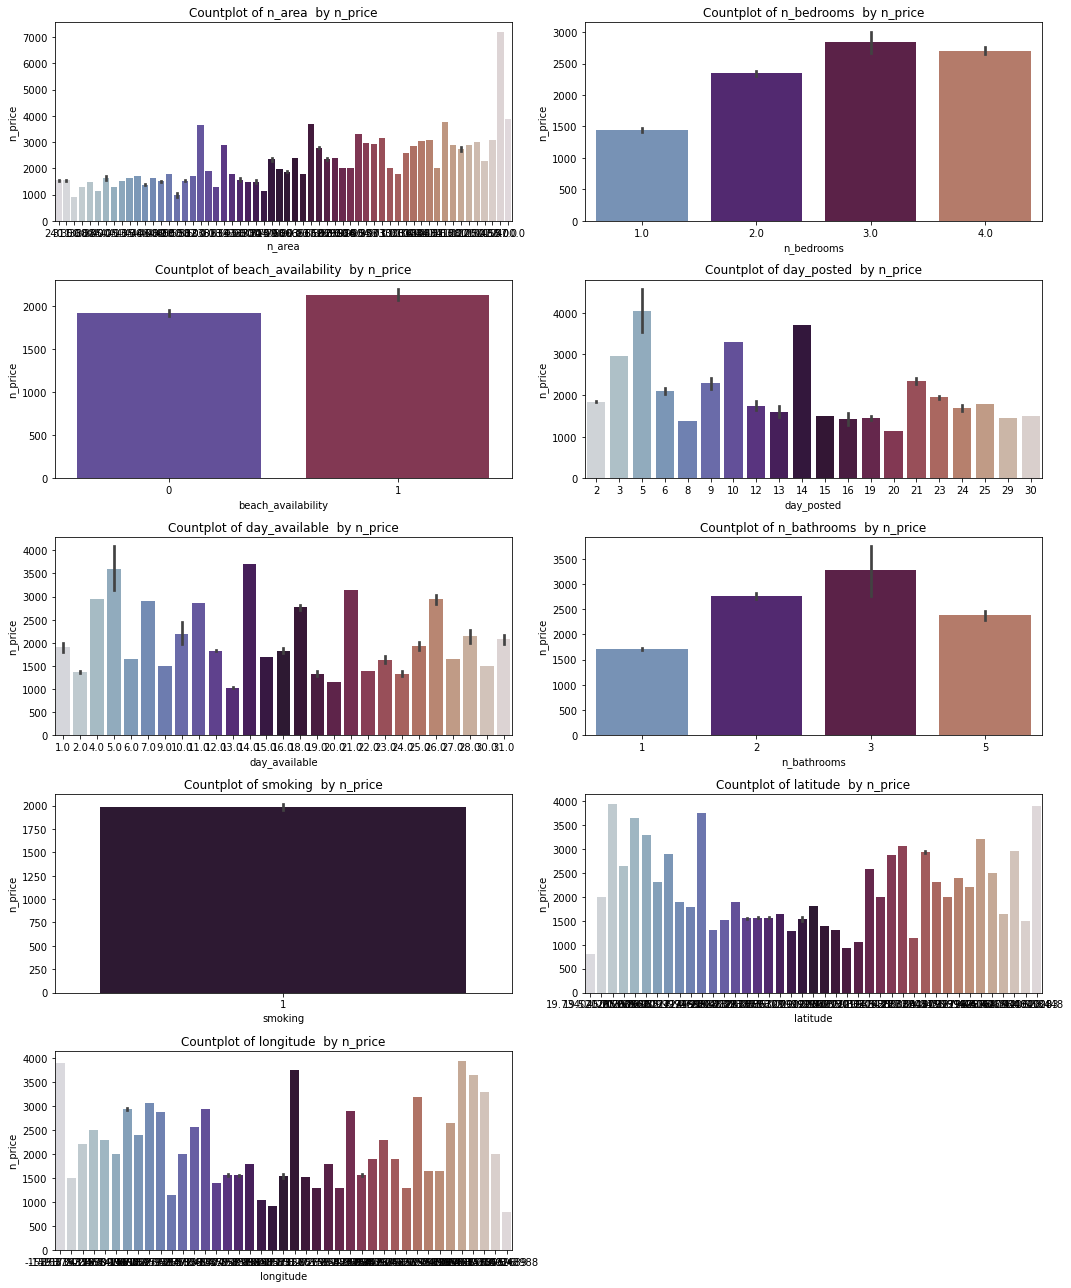

In [426]:
plot_data_EDA(df)

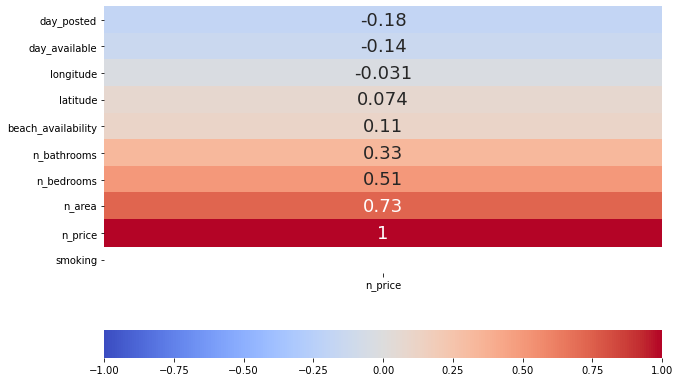

In [427]:
fig = plt.figure(figsize = (10,7))
#fig.suptitle('Comparison of the feature correlation done before and after feature engineering', fontsize = 30)
g = sns.heatmap(df.corr()[['n_price']].sort_values(by='n_price'), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1, annot_kws={"size": 18} , cbar_kws={"orientation": "horizontal"},
               xticklabels=True, yticklabels=True)

Summary of EDA analysis: how the independent features influence the dependent feature (n_price)

1. n_area: as n_area increases n_price increases as well showing the positive linear corrleation with coeff of +0.73.
2. n_bedrooms: as n_bedrooms increases (from 1 - to 3) n_price decreases, nearly doubles peaking at three-bedroom apartments with coeff of +0.51.
3. n_bathrooms: no surprise bathrooms follow the bedrooms-n_price trend with +0.33 coeff.
4. beach_availability: places near the beach appears to be 10% more expensive than those away from the shore line.
5. day_posted and day_available both showed the negative correlation with n_price meaning that the early posted ads have higher rental price than those that posted later.
6. longitude: does not seem to have an influence onto the n_price
7. longitude: interesting that longitude but not latitude contributes to the n_price, as longitude goes from west to east the n_price increases. Our concern however lies mainly in Honolulu area, thus I would not take this into account yet. Lets check it later.


Columns fate
1. I will drop the columns that do not have future use:
smoking, day_available.
2. I plan to use the feature that did not show so far a significant correlation (day_posted, day_available, longitude, latitude) for future use when I can do the feature preprocessing to try to impove the correlation between those features and the target variable.

In [428]:
def plot_Hawaii(df):
    """
    plots image accoring to the apartments coordinates found in Hawaii islands
    """
    import matplotlib.image as mpimg
    img=plt.imread(r'C:\Users\valer\OneDrive\Desktop\haw.jpg')

    fig, ax = plt.subplots(figsize=(7,7), dpi = 300)
    ax.imshow(img, extent=[-160.00, -154.75, 19.42, 22.05])
    im = ax.scatter(x = df["longitude"], y=df["latitude"], c = df['n_price'], alpha=1, s = 20, cmap=plt.get_cmap("jet"))
    cbar = fig.colorbar(im, ax=ax, fraction=0.0237, pad=0.04)
    cbar.set_label('n_price', fontsize=10)
    plt.ylabel("Latitude", fontsize=14)
    plt.xlabel("Longitude", fontsize=14)
    return plt.show()

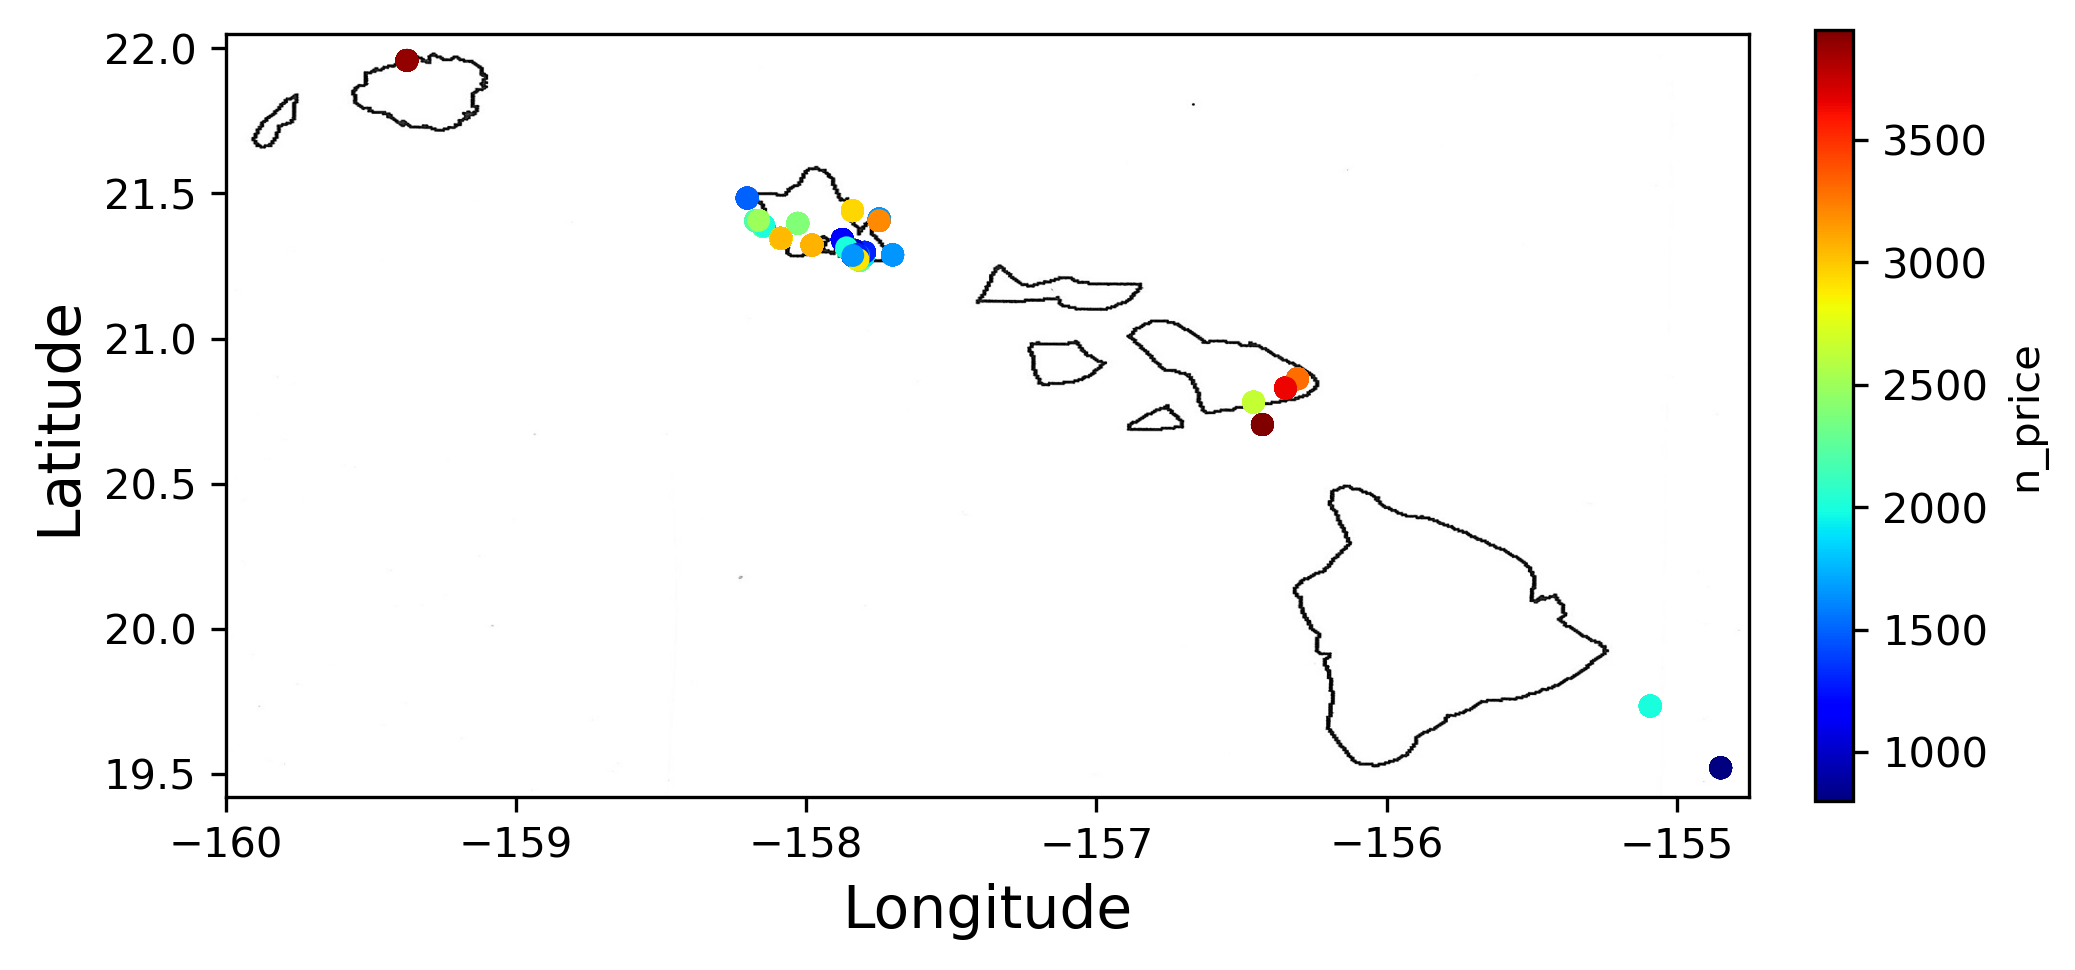

In [429]:
plot_Hawaii(df)

Lets have a closer look to the Oahu area

In [430]:
# get the Oahu coordinates
def oahu_coordinates(df):
    
    df_oahu = df[(df['longitude'] > -158.5) & (df['longitude'] < -157.5) 
             & (df['latitude'] > 21.00) & (df['latitude'] < 22.00)]
    return df_oahu

df_oahu = oahu_coordinates(df)

In [431]:
def plot_Oahu(df_oahu):
    """
    plots only Oahu island apartments 
    """
    fig, ax = plt.subplots(figsize=(4,4), dpi = 300)
    img_oahu=plt.imread(r'C:\Users\valer\OneDrive\Desktop\oah.jpg')

    ax.imshow(img_oahu, extent=[-158.50, -157.5, 21.20, 21.95])
    im = ax.scatter(x = df_oahu["longitude"], y=df_oahu["latitude"], c = df_oahu['n_price'], alpha=1, s = 10, cmap=plt.get_cmap("jet"))
    cbar = fig.colorbar(im, ax=ax, fraction=0.035, pad=0.04)
    cbar.set_label('n_price', fontsize=10)
    cbar.ax.tick_params(labelsize=5)
    plt.yticks(fontsize=5)
    plt.xticks(fontsize=5)
    plt.ylabel("Latitude", fontsize=5)
    plt.xlabel("Longitude", fontsize=5)
    return plt.show()

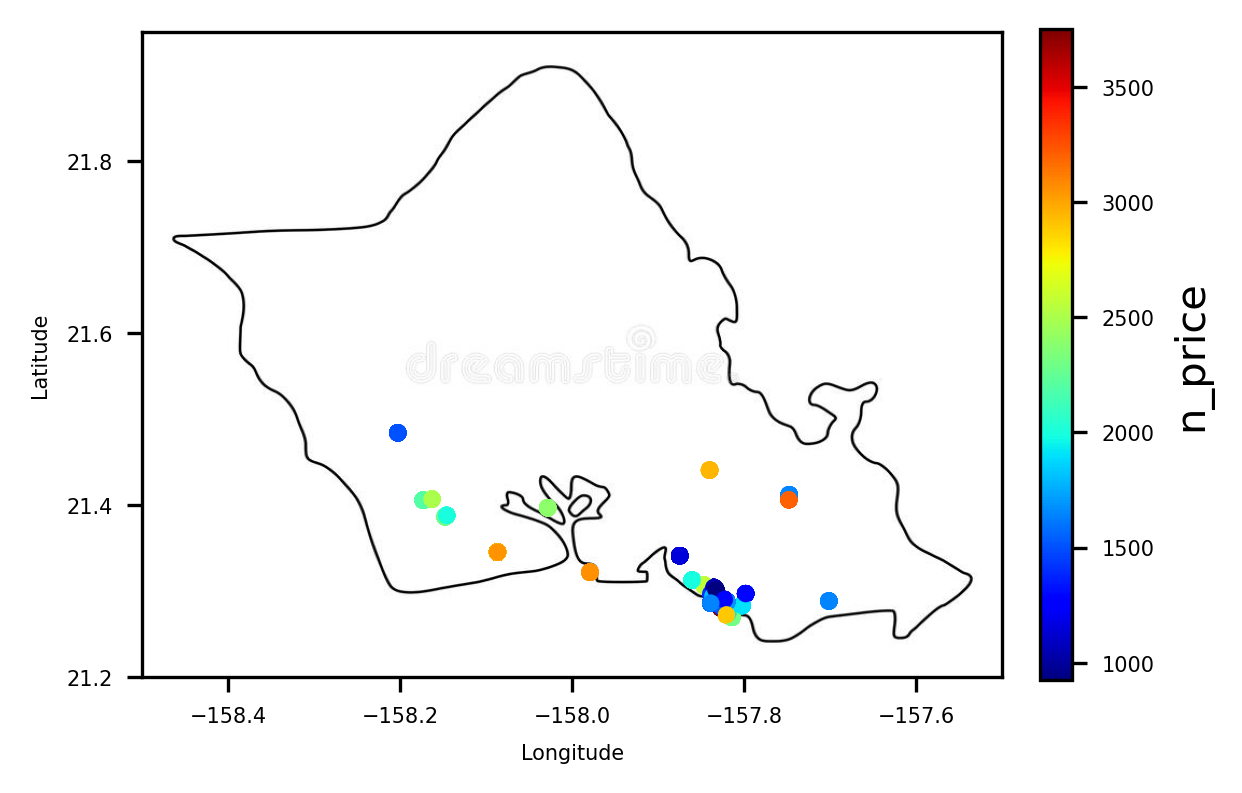

In [432]:
plot_Oahu(df_oahu)

Lets look at the Honolulu area

In [433]:
def Honolulu_coordinates(df):
    # get honolulu's coordinates
    df_hono = df[(df['longitude'] > -157.9) & (df['longitude'] < -157.75) & 
                 (df['latitude'] > 21.20) & (df['latitude'] < 21.37)]
    return df_hono

df_hono = Honolulu_coordinates(df)

In [434]:
def plot_Honolulu(df_hono):
    """
    plot Honolulu apartments
    """
    # upload Honolulu map
    fig, ax = plt.subplots(figsize=(4,4), dpi = 300)
    img_hono=plt.imread(r'C:\Users\valer\OneDrive\Desktop\cc.jpg')
    ax.imshow(img_hono, extent=[-157.88, -157.670, 21.233, 21.37])
    
    # map a scatter plot onto the Honolulu template
    im = ax.scatter(x = df_hono["longitude"], y=df_hono["latitude"], 
                    c = df_hono['n_price'], alpha=1, s = 5, cmap=plt.get_cmap("jet"))
    cbar = fig.colorbar(im, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('n_price', fontsize=5)
    cbar.ax.tick_params(labelsize=5)
    plt.yticks(fontsize=5)
    plt.xticks(fontsize=5)
    plt.ylabel("Latitude", fontsize=5)
    plt.xlabel("Longitude", fontsize=5)
    
    return plt.show()

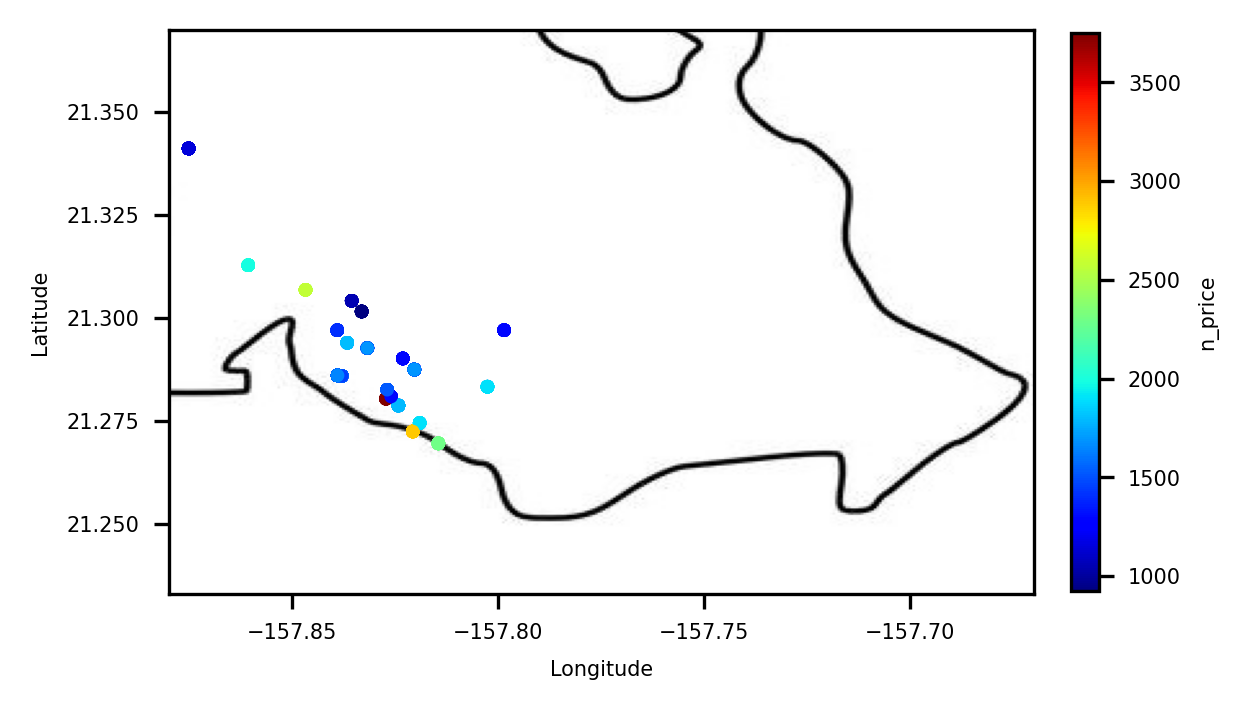

In [435]:
plot_Honolulu(df_hono)

Conclusion from investigation of the coordinates influence in the apartments price:

It looks like places closer to the shore have higher prices comparing with places farther from the beach. The major issue is that the number of houses with the available coordinates is very small comparing to the number of records in the dataset, meaning that we can not rely on the whatever correlation we might detect from the geo location data.

# Missing values imputation

In [436]:
# Lets get a general overview of the missing values number presented in the df
df.isna().sum()

n_area                 364
n_bedrooms             598
beach_availability       0
day_posted               0
day_available          910
n_bathrooms              0
smoking                  0
latitude              1350
longitude             1350
n_price                  0
dtype: int64

n_area is the feature with the most correlation to the target variable, thus we need to find the best way to impute it

In [437]:
# shape and data types of the data
print(df.shape)
print(df.dtypes)
print()
print('Numeric columns:')

# select numeric columns
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)
print()
print('Non-numeric columns:')

# select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

print()
print()

def non_numeric(df):
    '''
    checking null values
    '''
    df_numeric = df.select_dtypes(include=[np.number])
    
    if df_numeric.isnull().sum().sum() > 0:
        total_numeric = df_numeric.isnull().sum().sort_values(ascending=False) 
        total = total_numeric[total_numeric > 0]

        percent = df_numeric.isnull().mean().sort_values(ascending=False) 
        percent_ready = percent[percent > 0] 

        missing_data_numeric = pd.concat([total, percent_ready], axis=1, keys=['Total', 'Percent_ready'])
    
        print(missing_data_numeric)
    else: 
        print('No Missing values found in numeric.')
        
def numeric(df):
    '''
    checking null values
    '''
    df_non_numeric = df.select_dtypes(exclude=[np.number])
    
    if df_non_numeric.isnull().sum().sum() > 0:
        total_non_numeric = df_non_numeric.isnull().sum().sort_values(ascending=False) 
        total = total_non_numeric[total_non_numeric > 0]

        percent = df_non_numeric.isnull().mean().sort_values(ascending=False) 
        percent_ready = percent[percent > 0] 

        missing_data_non_numeric = pd.concat([total, percent_ready], axis=1, keys=['Total', 'Percent_ready'])
    
        print(missing_data_non_numeric)
    else: 
        print('No Missing values found in non-numeric.')

        
print('Total and Percentage of Missing values in numeric:\n')
non_numeric(df)
print()
print()
print()

numeric(df)

(3120, 10)
n_area                float64
n_bedrooms            float64
beach_availability      int32
day_posted              int32
day_available         float64
n_bathrooms             int32
smoking                 int32
latitude              float64
longitude             float64
n_price                 int32
dtype: object

Numeric columns:
['n_area' 'n_bedrooms' 'beach_availability' 'day_posted' 'day_available'
 'n_bathrooms' 'smoking' 'latitude' 'longitude' 'n_price']

Non-numeric columns:
[]


Total and Percentage of Missing values in numeric:

               Total  Percent_ready
longitude       1350       0.432692
latitude        1350       0.432692
day_available    910       0.291667
n_bedrooms       598       0.191667
n_area           364       0.116667



No Missing values found in non-numeric.


Longitude and latitude have the highest percent of the missing values. The problem is that they are the unique values corresponding to the geo location of the apartments. I do not know how to impute it, thus as they do not really correlate with the target feature, I just drop them. Drop day_available as well due to the relatively low negative correlation with n_price.

In [438]:
def plot_missing_values(df):
    import seaborn as sns
    cols = df.columns # first 30 columns
    plt.figure(figsize=(16, 6))
    colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
    return sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

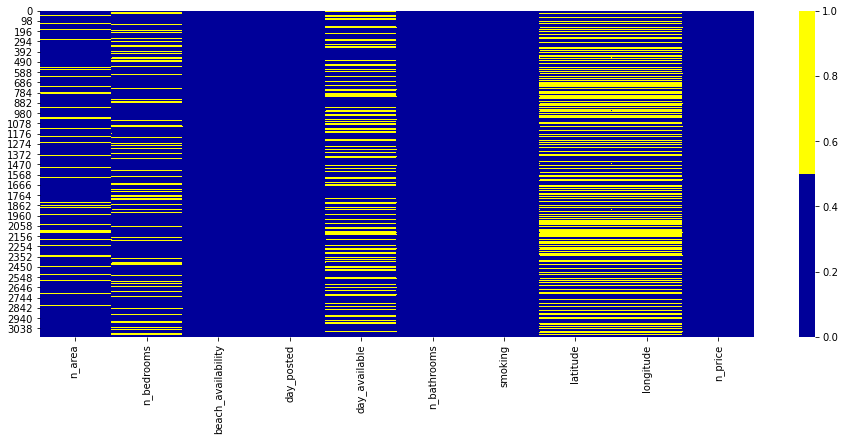

In [439]:
plot_missing_values(df)

There are various method for the missing values imputation. Here I will try the most commonly used ones:
1. Dropping columns of missing values.
2. Imputation of missing values by their mean.
3. Imputation of missing values by their mode (especially useful for categorical features).
4. Imputation of missing values by their median.
5. Imputation of missing values by random selection.
6. Imputation of missing values by regression model.
6. Imputation of missing values by KNN.
6. Imputation of missing values by outliers.
6. Imputation of missing values by other feature.

Lets impute n_area firstly as the most important predictor so far (+73 corr coeff)

In [440]:
#dropping columns
def drop_nan(df, variable):
    df[variable+'_dropped'] = df[variable].fillna(0)
    return df

# mode imputation
def impute_nan_mode(df, variable):
    df[variable+'_mode'] = df[variable].fillna(2.0)
    return df

# median imputation
def impute_nan_median(df, variable):
    median = df[variable].median()
    df[variable+'_median'] = df[variable].fillna(median)
    return df

# Random sample imputation peaks random data to replace the nan values applied for MCAR
def impute_nan_random(df,variable):
    median = df[variable].median()
    df[variable+"_median"]=df[variable].fillna(median)
    df[variable+"_random"]=df[variable]
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable+'_random']=random_sample
    variable = df['n_area']
    return df

# regression_imputer
def Regression(df):
    reg_imputer = IterativeImputer(max_iter=10, random_state=123)
    vals = df['n_area'].values.reshape(-1,1)
    reg_imputer.fit(vals)
    df['n_area_regression'] = reg_imputer.transform(vals)
    return df

# KNN imputation
def impute_KNN(df):
    from sklearn.impute import KNNImputer
    knn_imputer = KNNImputer(n_neighbors=3)
    inputt = df['n_area'].values.reshape(-1,1)
    knn_imputer.fit(inputt)
    knn_imputer.transform(inputt)
    df['n_area_KNN'] = inputt 
    return df

# by outliers
def impute_by_outliers(df):
    extreme = df.n_area.mean() + 3*df.n_area.std()
    df['n_area_extreme'] = df['n_area'].fillna(extreme)
    return df

# group by Price. Trying to predict the missing n_bedrooms by the grouping known n_bedrooms by apartment price, and 
# filling unknown n_bedrooms values that corresponds to the n_price variable
def impute_by_Price(df, variable1, variable2):
    df[variable1 + '_by_' + variable2] = df[variable1].fillna(df.groupby(variable2)[variable1].transform('median'))
    return df

In [441]:
drop_nan(df, 'n_area')
impute_nan_mode(df, 'n_area')
impute_nan_median(df, 'n_area')
impute_nan_random(df,'n_area')
impute_by_Price(df, 'n_area', 'n_price')
Regression(df)
impute_KNN(df)
impute_by_outliers(df)

n_area  n_bedrooms  beach_availability  day_posted  day_available  \
0      800.0         NaN                   1          16            NaN   
1      480.0         1.0                   0          19           19.0   
2      380.0         NaN                   1          30           30.0   
3      400.0         1.0                   0          24            NaN   
4      650.0         1.0                   0          24           24.0   
...      ...         ...                 ...         ...            ...   
3115   650.0         2.0                   0          23           24.0   
3116  1188.0         2.0                   1          23            7.0   
3117  1000.0         2.0                   0          16            NaN   
3118   750.0         2.0                   1          23            1.0   
3119   460.0         1.0                   1          21           27.0   

      n_bathrooms  smoking   latitude   longitude  n_price  n_area_dropped  \
0               1        1        NaN         NaN     1950           800.0   
1               1        1  21.287535 -157.820367     1520           480.0   
2               1        1  21.286107 -157.838986     1500           380.0   
3               1        1        NaN         NaN     1380           400.0   
4               1        1        NaN         NaN     1025           650.0   
...           ...      ...        ...         ...      ...             ...   
3115            1        1        NaN         NaN     1900           650.0   
3116            2        1  21.272499 -157.820749     2895          1188.0   
3117            5        1        NaN         NaN     1800          1000.0   
3118            5        1  20.780922 -156.458284     2650           750.0   
3119            1        1  21.286107 -157.838986     1650           460.0   

      n_area_mode  n_area_median  n_area_random  n_area_by_n_price  \
0           800.0          800.0          800.0              800.0   
1           480.0          480.0          480.0              480.0   
2           380.0          380.0          380.0              380.0   
3           400.0          400.0          400.0              400.0   
4           650.0          650.0          650.0              650.0   
...           ...            ...            ...                ...   
3115        650.0          650.0          650.0              650.0   
3116       1188.0         1188.0         1188.0             1188.0   
3117       1000.0         1000.0         1000.0             1000.0   
3118        750.0          750.0          750.0              750.0   
3119        460.0          460.0          460.0              460.0   

      n_area_regression  n_area_KNN  n_area_extreme  
0                 800.0       800.0           800.0  
1                 480.0       480.0           480.0  
2                 380.0       380.0           380.0  
3                 400.0       400.0           400.0  
4                 650.0       650.0           650.0  
...                 ...         ...             ...  
3115              650.0       650.0           650.0  
3116             1188.0      1188.0          1188.0  
3117             1000.0      1000.0          1000.0  
3118              750.0       750.0           750.0  
3119              460.0       460.0           460.0  

[3120 rows x 18 columns]

In [442]:
def plot_imputed_bedrooms(df):
    """
    this plots the orifinal distribution of the area variable and the distributions 
    obtained after the imputations of the missing values. The goal is to find imputation that is
    closely correlated to the otiginal distribution (grey color)
    """
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize = (17,7))
    ax = fig.add_subplot(111)

    df.n_area.plot(kind='kde', ax=ax, color = 'black',  linewidth=15, alpha=0.1)
    df.n_area_dropped.plot(kind='kde', ax=ax, color = 'yellow',  linewidth=7)
    df.n_area_mode.plot(kind='kde', ax=ax, color = 'magenta',linewidth=7)
    df.n_area_median.plot(kind='kde', ax=ax, color='red',linewidth=7)
    df.n_area_random.plot(kind='kde', ax=ax, color='orange',linewidth=7)
    df.n_area_by_n_price.plot(kind='kde', ax=ax, color='cyan',linewidth=7)
    df.n_area_regression.plot(kind='kde', ax=ax, color='green',linewidth=7)
    df.n_area_KNN.plot(kind='kde', ax=ax, color='grey',linewidth=7)
    df.n_area_extreme.plot(kind='kde', ax=ax, color='blue',linewidth=7)

    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
    plt.legend(fontsize=20) # using a size in points
    plt.legend(fontsize="xx-large") # using a named size

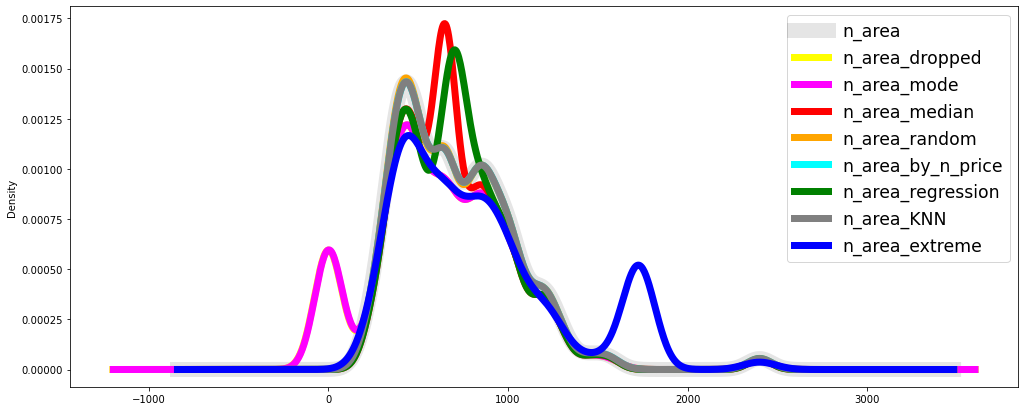

In [443]:
plot_imputed_bedrooms(df)

In [444]:
def best_candidates_bedrooms_missing(df):
    """
    checking the candidates for the n_area distribution
    """
    fig = plt.figure(figsize = (15,7))
    ax = fig.add_subplot(111)
    df.n_area.plot(kind='kde', ax=ax, color='blue', linewidth = 20, alpha = 0.5)
    df.n_area_random.plot(kind='kde', ax=ax, color='red', linewidth = 10)
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
    plt.legend(fontsize="xx-large")

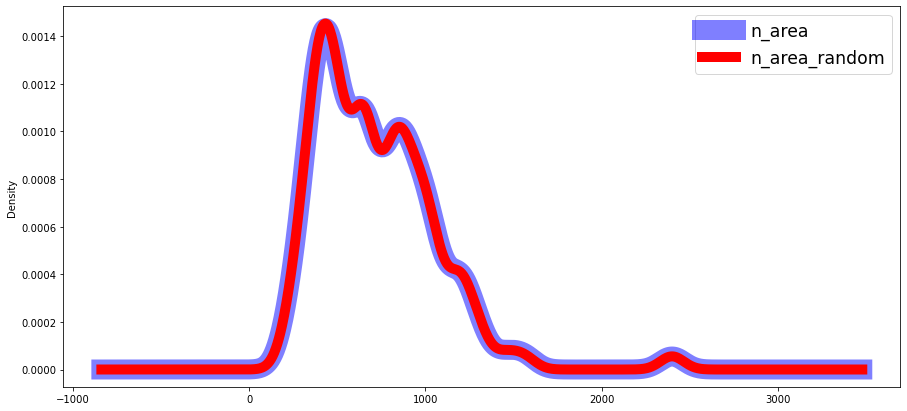

In [445]:
best_candidates_bedrooms_missing(df)

n_area_random imputed by random imputer demonstrated the best fit for the initial distribution of the n_area variable. Thus we will stick with this one. Dropped one showed the same dist, but we do not want to loose information by dropping the 10% of the dataset

Now lets impute the n_bedrooms feature: important feature with 0.53+ corr coeff. It is categorical, thus the regression models would not work

In [446]:
#dropping columns
def drop_nan(df, variable):
    df[variable+'_dropped'] = df[variable].fillna(0)
    return df

# mode imputation
def impute_nan_mode(df, variable):
    df[variable+'_mode'] = df[variable].fillna(2.0)
    return df

# median imputation
def impute_nan_median(df, variable):
    median = df[variable].median()
    df[variable+'_median'] = df[variable].fillna(median)
    return df

# Random sample imputation peaks random data to replace the nan values applied for MCAR
def impute_nan_random(df,variable):
    median = df[variable].median()
    df[variable+"_median"]=df[variable].fillna(median)
    df[variable+"_random"]=df[variable]
    random_sample=df[variable].dropna().sample(df[variable].isnull().sum(),random_state=0)
    random_sample.index=df[df[variable].isnull()].index
    df.loc[df[variable].isnull(),variable+'_random']=random_sample
    variable = df['n_bedrooms']
    return df

# group by Price. Trying to predict the missing n_bedrooms by the grouping known n_bedrooms by apartment price, and 
# filling unknown n_bedrooms values that corresponds to the n_price variable
def impute_by_Price(df, variable1, variable2):
    df[variable1 + '_by_' + variable2] = df[variable1].fillna(df.groupby(variable2)[variable1].transform('median'))
    return df

In [447]:
drop_nan(df, 'n_bedrooms')
impute_nan_mode(df, 'n_bedrooms')
impute_nan_median(df, 'n_bedrooms')
impute_nan_random(df,'n_bedrooms')
impute_by_Price(df, 'n_bedrooms', 'n_price')

n_area  n_bedrooms  beach_availability  day_posted  day_available  \
0      800.0         NaN                   1          16            NaN   
1      480.0         1.0                   0          19           19.0   
2      380.0         NaN                   1          30           30.0   
3      400.0         1.0                   0          24            NaN   
4      650.0         1.0                   0          24           24.0   
...      ...         ...                 ...         ...            ...   
3115   650.0         2.0                   0          23           24.0   
3116  1188.0         2.0                   1          23            7.0   
3117  1000.0         2.0                   0          16            NaN   
3118   750.0         2.0                   1          23            1.0   
3119   460.0         1.0                   1          21           27.0   

      n_bathrooms  smoking   latitude   longitude  n_price  n_area_dropped  \
0               1        1        NaN         NaN     1950           800.0   
1               1        1  21.287535 -157.820367     1520           480.0   
2               1        1  21.286107 -157.838986     1500           380.0   
3               1        1        NaN         NaN     1380           400.0   
4               1        1        NaN         NaN     1025           650.0   
...           ...      ...        ...         ...      ...             ...   
3115            1        1        NaN         NaN     1900           650.0   
3116            2        1  21.272499 -157.820749     2895          1188.0   
3117            5        1        NaN         NaN     1800          1000.0   
3118            5        1  20.780922 -156.458284     2650           750.0   
3119            1        1  21.286107 -157.838986     1650           460.0   

      n_area_mode  n_area_median  n_area_random  n_area_by_n_price  \
0           800.0          800.0          800.0              800.0   
1           480.0          480.0          480.0              480.0   
2           380.0          380.0          380.0              380.0   
3           400.0          400.0          400.0              400.0   
4           650.0          650.0          650.0              650.0   
...           ...            ...            ...                ...   
3115        650.0          650.0          650.0              650.0   
3116       1188.0         1188.0         1188.0             1188.0   
3117       1000.0         1000.0         1000.0             1000.0   
3118        750.0          750.0          750.0              750.0   
3119        460.0          460.0          460.0              460.0   

      n_area_regression  n_area_KNN  n_area_extreme  n_bedrooms_dropped  \
0                 800.0       800.0           800.0                 0.0   
1                 480.0       480.0           480.0                 1.0   
2                 380.0       380.0           380.0                 0.0   
3                 400.0       400.0           400.0                 1.0   
4                 650.0       650.0           650.0                 1.0   
...                 ...         ...             ...                 ...   
3115              650.0       650.0           650.0                 2.0   
3116             1188.0      1188.0          1188.0                 2.0   
3117             1000.0      1000.0          1000.0                 2.0   
3118              750.0       750.0           750.0                 2.0   
3119              460.0       460.0           460.0                 1.0   

      n_bedrooms_mode  n_bedrooms_median  n_bedrooms_random  \
0                 2.0                2.0                2.0   
1                 1.0                1.0                1.0   
2                 2.0                2.0                3.0   
3                 1.0                1.0                1.0   
4                 1.0                1.0                1.0   
...               ...                ...        

In [448]:
def plot_imputed_bedrooms(df):
    
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize = (17,7))
    ax = fig.add_subplot(111)
    
    df.n_bedrooms.plot(kind='kde', ax=ax, color = 'black',  linewidth=15, alpha=0.1)
    df.n_bedrooms_dropped.plot(kind='kde', ax=ax, color = 'yellow',  linewidth=7)
    df.n_bedrooms_mode.plot(kind='kde', ax=ax, color = 'magenta',linewidth=7)
    df.n_bedrooms_median.plot(kind='kde', ax=ax, color='red',linewidth=7)
    df.n_bedrooms_by_n_price.plot(kind='kde', ax=ax, color='cyan',linewidth=7)

    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
    plt.legend(fontsize=20) # using a size in points
    plt.legend(fontsize="xx-large") # using a named size

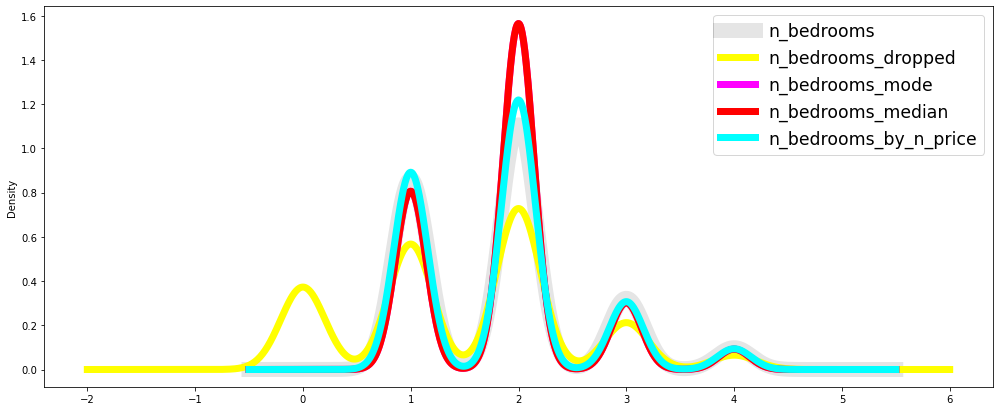

In [449]:
plot_imputed_bedrooms(df)

In [450]:
def best_candidates_bedrooms_missing(df):
    
    fig = plt.figure(figsize = (15,7))
    ax = fig.add_subplot(111)
    df.n_bedrooms.plot(kind='kde', ax=ax, color='blue', linewidth = 20, alpha = 0.5)
    df.n_bedrooms_mode.plot(kind='kde', ax=ax, color = 'magenta',linewidth=7)
    lines, labels = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
    plt.legend(fontsize="xx-large")

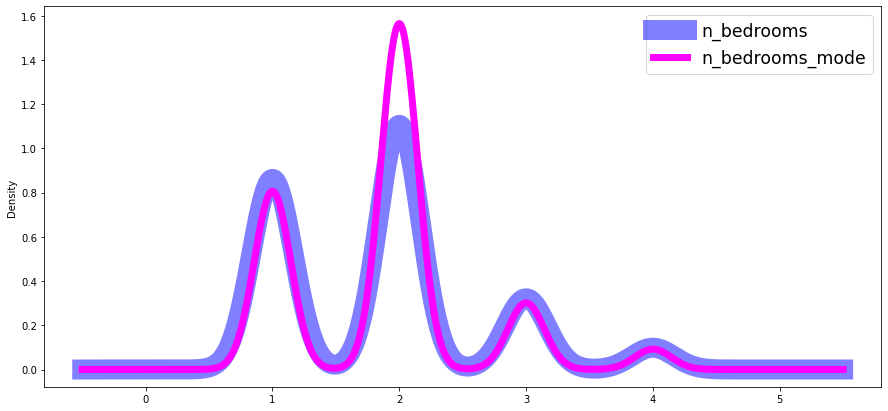

In [451]:
best_candidates_bedrooms_missing(df)

Probably, the best distribution of feature with newly imputed values we could get. Lets stick with the mode_imputer.
The other columns that have missing values did not show a significant correlation with the target feature, thus we can impute by median or by any other technique.

In [452]:
df

n_area  n_bedrooms  beach_availability  day_posted  day_available  \
0      800.0         NaN                   1          16            NaN   
1      480.0         1.0                   0          19           19.0   
2      380.0         NaN                   1          30           30.0   
3      400.0         1.0                   0          24            NaN   
4      650.0         1.0                   0          24           24.0   
...      ...         ...                 ...         ...            ...   
3115   650.0         2.0                   0          23           24.0   
3116  1188.0         2.0                   1          23            7.0   
3117  1000.0         2.0                   0          16            NaN   
3118   750.0         2.0                   1          23            1.0   
3119   460.0         1.0                   1          21           27.0   

      n_bathrooms  smoking   latitude   longitude  n_price  n_area_dropped  \
0               1        1        NaN         NaN     1950           800.0   
1               1        1  21.287535 -157.820367     1520           480.0   
2               1        1  21.286107 -157.838986     1500           380.0   
3               1        1        NaN         NaN     1380           400.0   
4               1        1        NaN         NaN     1025           650.0   
...           ...      ...        ...         ...      ...             ...   
3115            1        1        NaN         NaN     1900           650.0   
3116            2        1  21.272499 -157.820749     2895          1188.0   
3117            5        1        NaN         NaN     1800          1000.0   
3118            5        1  20.780922 -156.458284     2650           750.0   
3119            1        1  21.286107 -157.838986     1650           460.0   

      n_area_mode  n_area_median  n_area_random  n_area_by_n_price  \
0           800.0          800.0          800.0              800.0   
1           480.0          480.0          480.0              480.0   
2           380.0          380.0          380.0              380.0   
3           400.0          400.0          400.0              400.0   
4           650.0          650.0          650.0              650.0   
...           ...            ...            ...                ...   
3115        650.0          650.0          650.0              650.0   
3116       1188.0         1188.0         1188.0             1188.0   
3117       1000.0         1000.0         1000.0             1000.0   
3118        750.0          750.0          750.0              750.0   
3119        460.0          460.0          460.0              460.0   

      n_area_regression  n_area_KNN  n_area_extreme  n_bedrooms_dropped  \
0                 800.0       800.0           800.0                 0.0   
1                 480.0       480.0           480.0                 1.0   
2                 380.0       380.0           380.0                 0.0   
3                 400.0       400.0           400.0                 1.0   
4                 650.0       650.0           650.0                 1.0   
...                 ...         ...             ...                 ...   
3115              650.0       650.0           650.0                 2.0   
3116             1188.0      1188.0          1188.0                 2.0   
3117             1000.0      1000.0          1000.0                 2.0   
3118              750.0       750.0           750.0                 2.0   
3119              460.0       460.0           460.0                 1.0   

      n_bedrooms_mode  n_bedrooms_median  n_bedrooms_random  \
0                 2.0                2.0                2.0   
1                 1.0                1.0                1.0   
2                 2.0                2.0                3.0   
3                 1.0                1.0                1.0   
4                 1.0                1.0                1.0   
...               ...                ...        

Lets select features for future preprocessing

Some predictors showed the lower correlaton coefficient, this however do not mean that we should exclude them from our consideration. There are methods that allow nonlinear feature selection and might shed light onto the hidden and nonlinear dependencies between the n_price and predictors.

In [453]:
df = df[['beach_availability', 'n_area_random', 'n_bedrooms_mode', 'n_bathrooms',
          'day_posted', 'n_price']]

# Feature Engineering 

In [454]:
df.head()

beach_availability  n_area_random  n_bedrooms_mode  n_bathrooms  \
0                   1          800.0              2.0            1   
1                   0          480.0              1.0            1   
2                   1          380.0              2.0            1   
3                   0          400.0              1.0            1   
4                   0          650.0              1.0            1   

   day_posted  n_price  
0          16     1950  
1          19     1520  
2          30     1500  
3          24     1380  
4          24     1025

In [455]:
#to save an old dataframe to compare with the modified one after feature engineering
df_old = df.copy()

In [456]:
def new_features(df):
    """
    for further investifation it is important to create new features that may reduce the amount of predictors
    """
    # lets normalize the price variable. The most sense would make to divide calculate the price of 1 meter.
    df['cost_square_meter'] = (df['n_price']/df['n_area_random'])/0.092903 # feet to meters
    # convert to numerical values coercing errors
    df['bedrooms_to_bathrooms'] = df['n_bedrooms_mode']/df['n_bathrooms']
    
    """
    take the diff between posted and the todays date
    data got scraped on the 24th of July
    """
    df['day_diff'] = df['day_posted'].apply(lambda x: (24 - x) if x <=24 else (24 + 30 - x))
    return df

In [457]:
df_new = new_features(df)

In [458]:
df_new.shape

(3120, 9)

# Feature Selection 

Lets check the features that we have already desinged: how they influence the other variables and the target feature.

In [459]:
df_new.head()

beach_availability  n_area_random  n_bedrooms_mode  n_bathrooms  \
0                   1          800.0              2.0            1   
1                   0          480.0              1.0            1   
2                   1          380.0              2.0            1   
3                   0          400.0              1.0            1   
4                   0          650.0              1.0            1   

   day_posted  n_price  cost_square_meter  bedrooms_to_bathrooms  day_diff  
0          16     1950          26.237043                    2.0         8  
1          19     1520          34.085731                    1.0         5  
2          30     1500          42.489138                    2.0        24  
3          24     1380          37.135507                    1.0         0  
4          24     1025          16.973866                    1.0         0

In [460]:
df_new.columns

Index(['beach_availability', 'n_area_random', 'n_bedrooms_mode', 'n_bathrooms',
       'day_posted', 'n_price', 'cost_square_meter', 'bedrooms_to_bathrooms',
       'day_diff'],
      dtype='object')

In [461]:
df_new

beach_availability  n_area_random  n_bedrooms_mode  n_bathrooms  \
0                      1          800.0              2.0            1   
1                      0          480.0              1.0            1   
2                      1          380.0              2.0            1   
3                      0          400.0              1.0            1   
4                      0          650.0              1.0            1   
...                  ...            ...              ...          ...   
3115                   0          650.0              2.0            1   
3116                   1         1188.0              2.0            2   
3117                   0         1000.0              2.0            5   
3118                   1          750.0              2.0            5   
3119                   1          460.0              1.0            1   

      day_posted  n_price  cost_square_meter  bedrooms_to_bathrooms  day_diff  
0             16     1950          26.237043                    2.0         8  
1             19     1520          34.085731                    1.0         5  
2             30     1500          42.489138                    2.0        24  
3             24     1380          37.135507                    1.0         0  
4             24     1025          16.973866                    1.0         0  
...          ...      ...                ...                    ...       ...  
3115          23     1900          31.463752                    2.0         1  
3116          23     2895          26.230248                    1.0         1  
3117          16     1800          19.375047                    0.4         8  
3118          23     2650          38.032500                    0.4         1  
3119          21     1650          38.609695                    1.0         3  

[3120 rows x 9 columns]

In [462]:
df_new.drop(columns = ['day_posted'], inplace = True)

In [463]:
df_new.columns

Index(['beach_availability', 'n_area_random', 'n_bedrooms_mode', 'n_bathrooms',
       'n_price', 'cost_square_meter', 'bedrooms_to_bathrooms', 'day_diff'],
      dtype='object')

In [464]:
df_new.columns = ['beach_availability', 'n_area_random', 'n_bedrooms_mode', 'n_bathrooms',
              'cost_square_meter', 'bedrooms_to_bathrooms', 'day_diff', 'n_price']

In [465]:
df_new.head()

beach_availability  n_area_random  n_bedrooms_mode  n_bathrooms  \
0                   1          800.0              2.0            1   
1                   0          480.0              1.0            1   
2                   1          380.0              2.0            1   
3                   0          400.0              1.0            1   
4                   0          650.0              1.0            1   

   cost_square_meter  bedrooms_to_bathrooms  day_diff  n_price  
0               1950              26.237043       2.0        8  
1               1520              34.085731       1.0        5  
2               1500              42.489138       2.0       24  
3               1380              37.135507       1.0        0  
4               1025              16.973866       1.0        0

Text(0.5, 1.0, 'New (after feature engineering)')

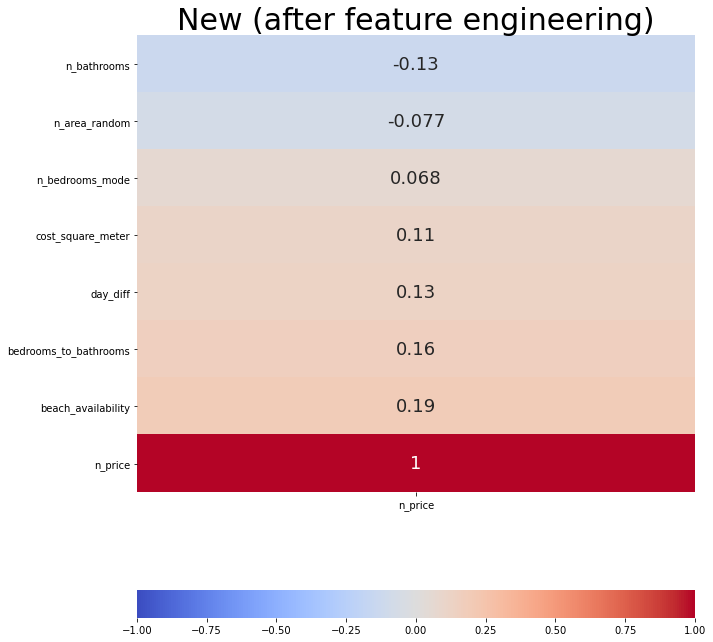

In [466]:
fig = plt.figure(figsize = (10,12))
#fig.suptitle('Comparison of the feature correlation done before and after feature engineering', fontsize = 30)
g = sns.heatmap(df_new.corr()[['n_price']].sort_values(by='n_price'), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1, annot_kws={"size": 18} , cbar_kws={"orientation": "horizontal"},
               xticklabels=True, yticklabels=True)

g.set_title('New (after feature engineering)', fontsize =30)


So, after feature engineering the strength of our predictorrs decreased dramatically, and beach_availability with 0.19 as the feature with the highest correlation. Thus, we decreased the model quality and should come back to the original one.

Text(0.5, 1.0, 'Old (Before feature engineering)')

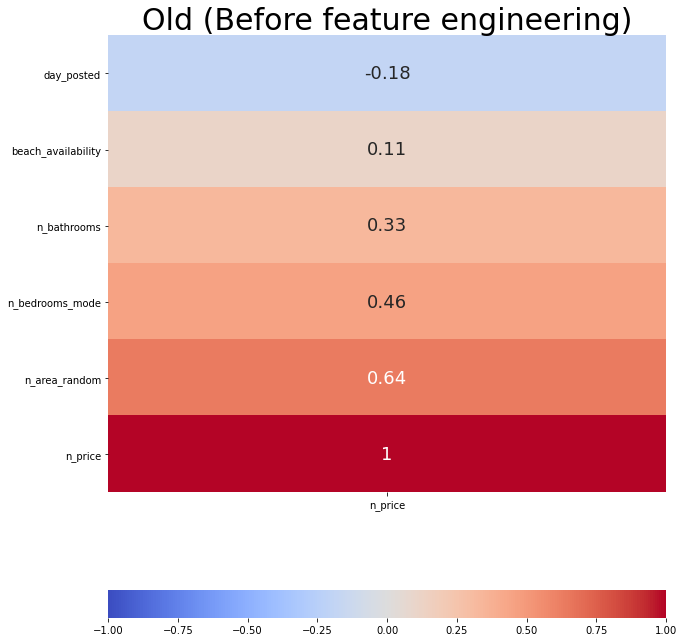

In [467]:
fig = plt.figure(figsize = (10,12))
#fig.suptitle('Comparison of the feature correlation done before and after feature engineering', fontsize = 30)
g = sns.heatmap(df_old.corr()[['n_price']].sort_values(by='n_price'), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1, annot_kws={"size": 18} , cbar_kws={"orientation": "horizontal"},
               xticklabels=True, yticklabels=True)

g.set_title('Old (Before feature engineering)', fontsize =30)

Even though we observed some decrease of the correlation coefficients between the target feature and n_area_random after we have impute the missing values by the random imputer (decrease from 0.73 tp 0.64), it is still much better than the new one with engineered features. Moreover, even though the decrease in old one was observed, we do want to introduce some bias in the model to avoid overfitting.


For now we have just concentrated onto the linear correlation between the predictors and the target variable. There are other models, tree based methods that can allow us to look into the nonlinear correlation:
1. Filter methods
2. Embedded methods

In [468]:
def plot_missing_values(df):
    import seaborn as sns
    cols = df.columns # first 30 columns
    plt.figure(figsize=(16, 6))
    colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
    return sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

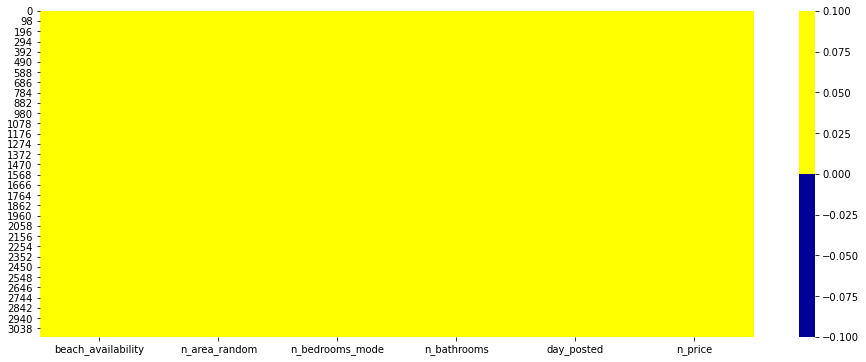

In [469]:
# checking out the missing values after imputations
plot_missing_values(df_old)

In [470]:
df_old

beach_availability  n_area_random  n_bedrooms_mode  n_bathrooms  \
0                      1          800.0              2.0            1   
1                      0          480.0              1.0            1   
2                      1          380.0              2.0            1   
3                      0          400.0              1.0            1   
4                      0          650.0              1.0            1   
...                  ...            ...              ...          ...   
3115                   0          650.0              2.0            1   
3116                   1         1188.0              2.0            2   
3117                   0         1000.0              2.0            5   
3118                   1          750.0              2.0            5   
3119                   1          460.0              1.0            1   

      day_posted  n_price  
0             16     1950  
1             19     1520  
2             30     1500  
3             24     1380  
4             24     1025  
...          ...      ...  
3115          23     1900  
3116          23     2895  
3117          16     1800  
3118          23     2650  
3119          21     1650  

[3120 rows x 6 columns]

In [471]:
df = df_old

In [472]:
#To select features I need to split the dataset to independent and dependent variables
X = df.drop('n_price', axis =1)
Y = df['n_price']

#train_tets_split to ensure no data would leak to test data  
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=1)

#Some of the feature selection algorithms require the scaling: Lasso & Ridge regressions
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

Filter methods


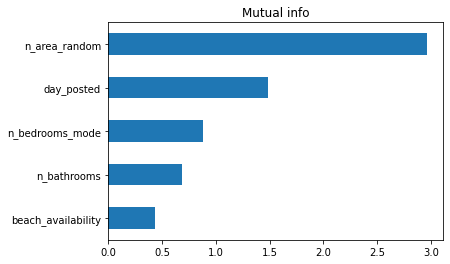

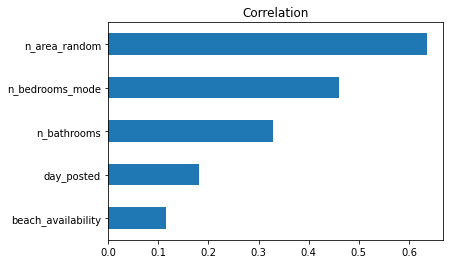

Embeded methods


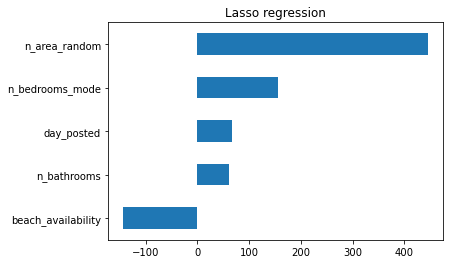

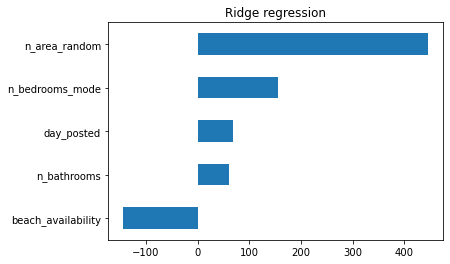

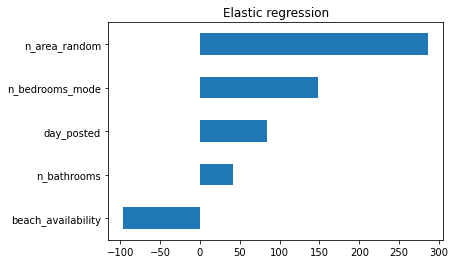

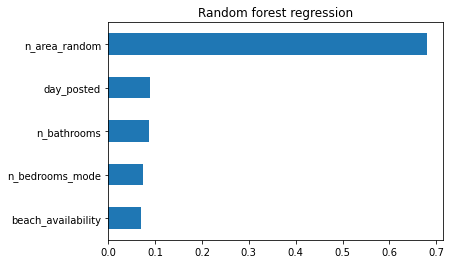

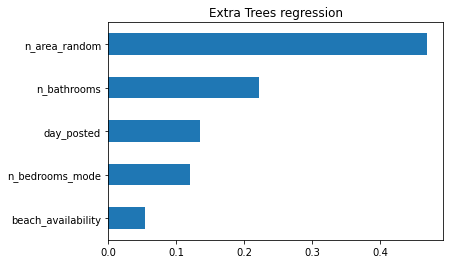

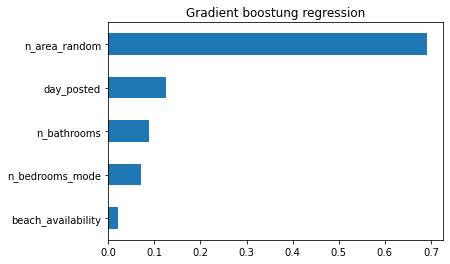

In [473]:
print('Filter methods')


#mutual info
from sklearn.feature_selection import mutual_info_regression
# determine the mutual information
mutual_info = mutual_info_regression(X_train, y_train)
mutual_info_series = pd.Series(mutual_info)
mutual_info_series.index = X_train.columns
mutual_info_series.sort_values(ascending=True).plot(kind='barh')
plt.title('Mutual info')
plt.show()



#Correlation
correlation=abs(df.corr()['n_price'])
del correlation['n_price']
correlation.sort_values(ascending=True).plot(kind='barh')
plt.title('Correlation')
plt.show()


print('Embeded methods')

#Lasso regression
lasso=Lasso()
lasso.fit(X_train_std,y_train)
lassocoeff = pd.Series((lasso.coef_), index=df.columns[:-1])
lassocoeff.sort_values(ascending=True).plot(kind='barh')
plt.title('Lasso regression')
#plt.show()
normLasso = lassocoeff/np.linalg.norm(lassocoeff)
normLasso = pd.Series(abs(normLasso), index=df.columns[:-1])
normLasso.sort_values(ascending=True).plot(kind='barh')
plt.title('Lasso regression')
plt.show()


#Ridge regression
ridge=Ridge()
ridge.fit(X_train_std,y_train)
ridgecoeff = pd.Series((ridge.coef_), index=X.columns)
ridgecoeff.sort_values(ascending=True).plot(kind='barh')

normRidge = ridgecoeff/np.linalg.norm(ridgecoeff)
normRidge = pd.Series(abs(normRidge), index=X.columns)
normRidge.sort_values(ascending=True).plot(kind='barh')
plt.title('Ridge regression')
plt.show()


#Elastic Net regression
elastic=ElasticNetCV()
elastic.fit(X_train_std,y_train)
elasticcoeff = pd.Series((elastic.coef_), index=df.columns[:-1])
elasticcoeff.sort_values(ascending=True).plot(kind='barh')
plt.title('Elastic regression')
normelastico = elasticcoeff/np.linalg.norm(elasticcoeff)
normelastico = pd.Series(abs(normelastico), index=df.columns[:-1])
normelastico.sort_values(ascending=True).plot(kind='barh')
plt.title('Elastic regression')
plt.show()

# Random forest regression
rf=RandomForestRegressor()
rf.fit(X_train_std ,y_train)
feat_importances2 = pd.Series(rf.feature_importances_, index=df.columns[:-1])
feat_importances2.sort_values(ascending=True).plot(kind='barh')
plt.title('Random forest regression')
plt.show()

#Extra Trees regression
et=ExtraTreesRegressor()
et.fit(X_train_std ,y_train)
feat_importances3 = pd.Series(et.feature_importances_, index=X.columns)
feat_importances3.sort_values(ascending=True).plot(kind='barh')
plt.title('Extra Trees regression')
plt.show()

#Gradient boostung regression
gbr=GradientBoostingRegressor()
gbr.fit(X_train_std,y_train)
feat_importances4 = pd.Series(gbr.feature_importances_, index=X.columns)
feat_importances4.sort_values(ascending=True).plot(kind='barh')
plt.title('Gradient boostung regression')
plt.show()


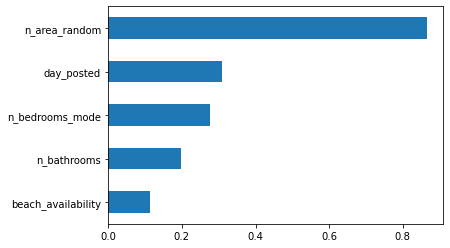

In [474]:
#lets assign random weight to each feature
import random


weight2= np.random.randint(1,10)/10
weight3= np.random.randint(1,10)/10
weight4= np.random.randint(1,10)/10
weight5= np.random.randint(1,10)/10
weight6= np.random.randint(1,10)/10
weight7= np.random.randint(1,10)/10
weight8= np.random.randint(1,10)/10
weight9= np.random.randint(1,10)/10
weight10= np.random.randint(1,10)/10

weightSum=weight2+weight3+weight4+weight5+weight6+weight7+weight8+weight9+weight10

#Compute the average
feat=(weight2*abs(correlation) + weight3*mutual_info + weight5*feat_importances2 + weight6*feat_importances3 + 
      weight5*feat_importances4 + weight8*normLasso + weight9*normRidge + 
      weight10*normelastico)/(weightSum)

#plot the results of the average sum
feat.sort_values(ascending=True).plot(kind='barh')
plt.show()

Based on the averaged results from the various feature selection method we have found that apartment area might be the most important variable while predicting n_price, which is quite reasonable. Following that predictor, we can see that number of bedrooms plays a significant role there as well.

Lets verify that the features do not have multicollinearity by calculating their variable inflation factor (VIF),which must be less than 5.

In [475]:
iv = X.columns  
# calculate the varience inflation factor 
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
  
# compare with each columns 
[vif(df[iv].values, index) for index in range(len(iv))]  
  
# Removing multicollinearity from the datset using vif  
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif 
  
# compare with each columns 
for i in range(len(iv)): 
    vif_list = [vif(df[iv].values, index) for index in range(len(iv))]  
    maxvif = max(vif_list) 
    print("Max VIF value is ", maxvif)                       
    drop_index = vif_list.index(maxvif) 
    print("For Independent variable", iv[drop_index]) 
     
    if maxvif > 6: 
         
        print("Deleting", iv[drop_index]) 
        iv = iv.delete(drop_index) 
        print("Final Independent_variables ", iv) 

Max VIF value is  9.77165523014663
For Independent variable n_bedrooms_mode
Deleting n_bedrooms_mode
Final Independent_variables  Index(['beach_availability', 'n_area_random', 'n_bathrooms', 'day_posted'], dtype='object')
Max VIF value is  5.303799621177193
For Independent variable n_area_random
Max VIF value is  5.303799621177193
For Independent variable n_area_random
Max VIF value is  5.303799621177193
For Independent variable n_area_random
Max VIF value is  5.303799621177193
For Independent variable n_area_random


VIF should not exceed 5 for teh robust model. In our case it is 5.30 which tolerable because otherwise we risk t drop our n_area feature which showed the highest correlation with the target one(n_price). Based on the VIF factor we can surely omit number of bedrooms as this feature showed strong multicollinearity and would inflate the variance of the target feature during the predictions.

In [500]:
def delete_columns(list_columns, df):

    """
    delete columns that are in the list based on the VIF
    """
    columns_valid = iv.to_list()
    columns_all = list_initial[:-1]
    
    from collections import Counter
    res_cols = list((Counter(list_initial[:-1])-Counter(list_columns)).elements())
    
    for col in res_cols:
        df.drop(columns = [col], inplace = True)
    return df

In [501]:
df_final = delete_columns(list_columns, df)

In [502]:
# the final dataframe
df_final

beach_availability  n_area_random  n_bathrooms  day_posted  n_price
0                      1          800.0            1          16     1950
1                      0          480.0            1          19     1520
2                      1          380.0            1          30     1500
3                      0          400.0            1          24     1380
4                      0          650.0            1          24     1025
...                  ...            ...          ...         ...      ...
3115                   0          650.0            1          23     1900
3116                   1         1188.0            2          23     2895
3117                   0         1000.0            5          16     1800
3118                   1          750.0            5          23     2650
3119                   1          460.0            1          21     1650

[3120 rows x 5 columns]

# Data preprocessing

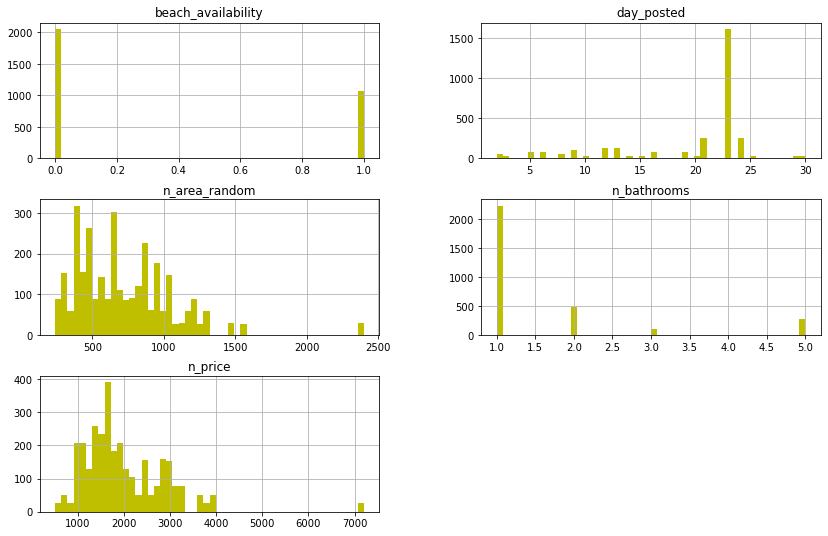

In [503]:
import matplotlib.pyplot as plt
df_final.hist(bins=50, figsize=(14,9), color = 'y')
plt.show()
    

We have two continious feature here: n_price and n_area.
Other features belong to categorical environment, so we could not do anything. For those continiuos features however that do not follow the gaussian distribution, we can modify their distributions bringing as close to Gaussian shaped as possible to improve the correlation between them and target feature.

Text(0.5, 1.0, 'Original correlations')

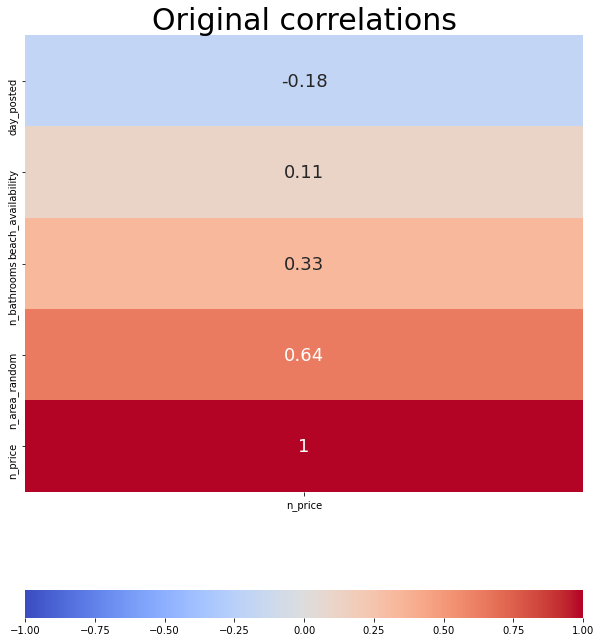

In [505]:
fig = plt.figure(figsize = (10,12))
#fig.suptitle('Comparison of the feature correlation done before and after feature engineering', fontsize = 30)
g = sns.heatmap(df_old.corr()[['n_price']].sort_values(by='n_price'), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1, annot_kws={"size": 18} , cbar_kws={"orientation": "horizontal"},
               xticklabels=True, yticklabels=True)

g.set_title('Original correlations', fontsize =30)

Lets start with the n_price variable

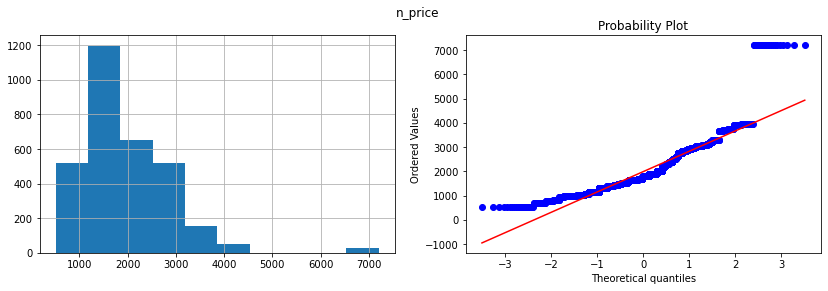

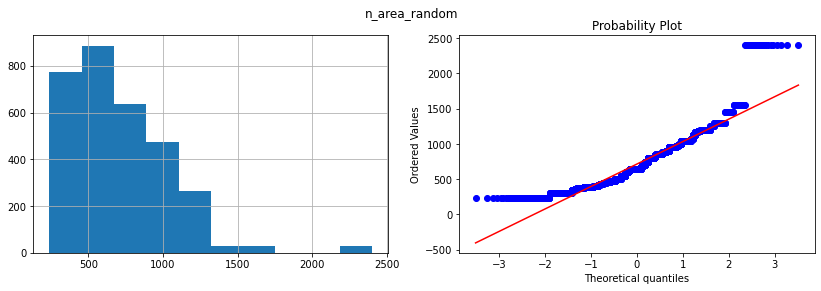

In [507]:
to_plot = ['n_price', 'n_area_random']
from scipy import stats
from matplotlib import pylab
from pylab import *

for f in to_plot:
    plt.figure(figsize=(14,4))
    
    plt.subplot(1,2,1)
    plt.suptitle(f)
    df[f].hist()
    plt.subplot(1,2,2)
    stats.probplot(df[f], dist = 'norm', plot = pylab)
    plt.show()

As we can see both variables have some outliers on the right hand site. We will deal with the outliers a bit later. For now lets modify the actual distribution, so it can mimic the gaussian one.

Lets try to convert cost_square_meter_mode to the standard normal distribution using the common transformations

1. reciprocal transformation
2. square root transformation
3. exponential transformation
4. logarithmic transformation




In [508]:
df_con = df.copy()
to_plot = ['n_price', 'n_area_random']

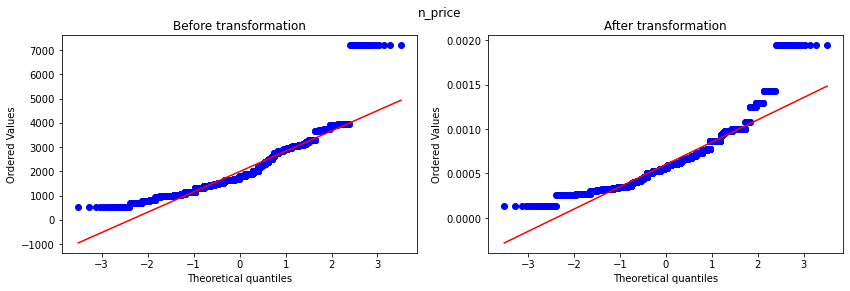

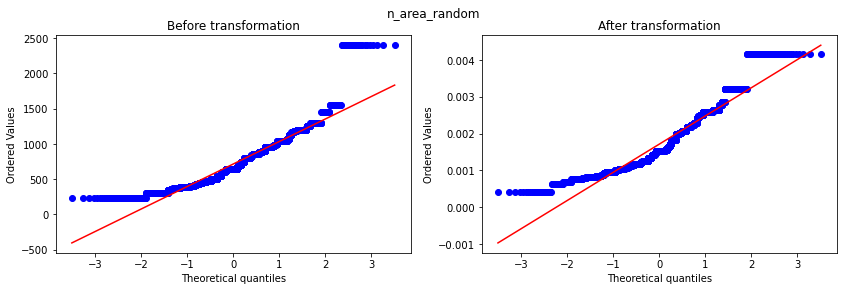

In [509]:
def reciprocal_trans(df):
    df_rec = pd.DataFrame()
    for f in to_plot:
        df_rec[f] = 1/df[f]
    df_rec.dropna(axis = 1, inplace = True)
    return df_rec

new_df_rec = pd.DataFrame()
new_df_rec = reciprocal_trans(df_con)

for f in to_plot:
    
    plt.figure(figsize=(14,4))
    
    plt.subplot(1,2,1)
    

    plt.suptitle(f)
    stats.probplot(df_con[f], dist = 'norm', plot = pylab)
    plt.title("Before transformation")
    
    
    plt.subplot(1,2,2)

    stats.probplot(new_df_rec[f], dist = 'norm', plot = pylab)
    plt.title("After transformation")
    plt.show()

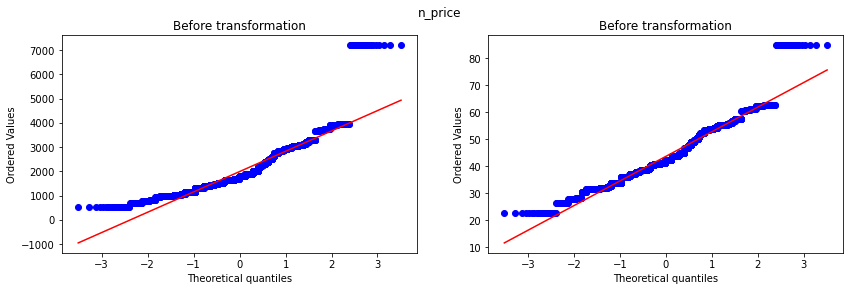

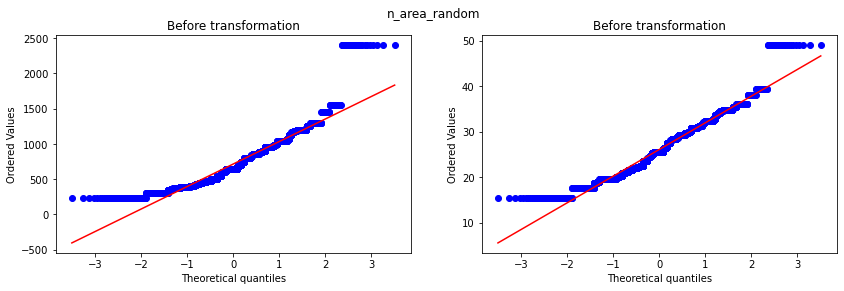

In [510]:
def sqrt_trans(df):
    df_sqrt = pd.DataFrame()
    for f in df.columns:
        df_sqrt[f] = df[f]**(1/2)
    df_sqrt.dropna(axis = 1, inplace = True)
    return df_sqrt

new_df_sqrt = sqrt_trans(df)

for f in to_plot:
    
    plt.figure(figsize=(14,4))
    
    plt.subplot(1,2,1)

    plt.suptitle(f)
    stats.probplot(df_con[f], dist = 'norm', plot = pylab)
    plt.title("Before transformation")
    
    plt.subplot(1,2,2)

    stats.probplot(new_df_sqrt[f], dist = 'norm', plot = pylab)
    plt.title("Before transformation")
    plt.show()

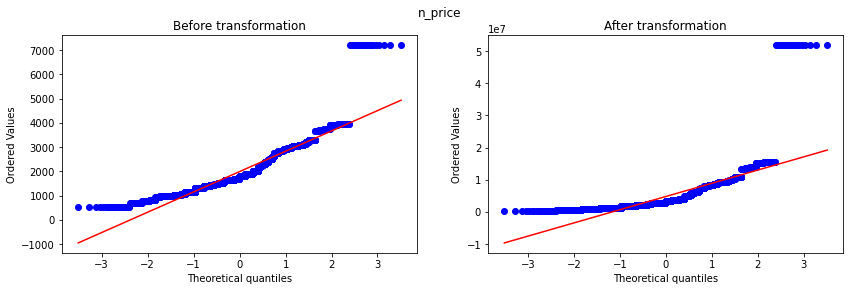

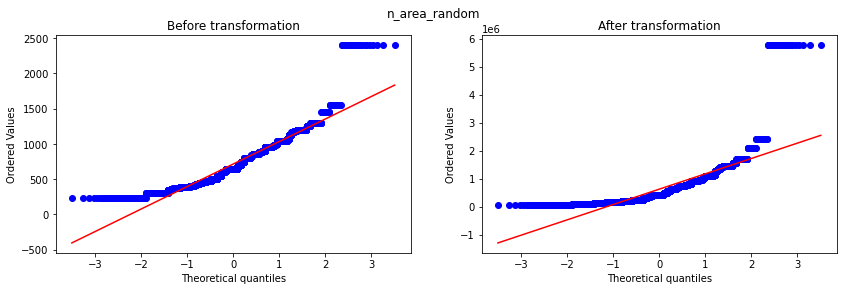

In [511]:
def exp_trans(df):
    df_exp = pd.DataFrame()
    for f in df.columns:
        df_exp[f] = df[f]**2
    df_exp.dropna(axis = 1, inplace = True)
    return df_exp

new_df_exp = exp_trans(df)

for f in to_plot:
    
    plt.figure(figsize=(14,4))
    
    plt.subplot(1,2,1)

    plt.suptitle(f)
    stats.probplot(df_con[f], dist = 'norm', plot = pylab)
    plt.title("Before transformation")
    plt.subplot(1,2,2)

    stats.probplot(new_df_exp[f], dist = 'norm', plot = pylab)
    plt.title("After transformation")
    plt.show()
    

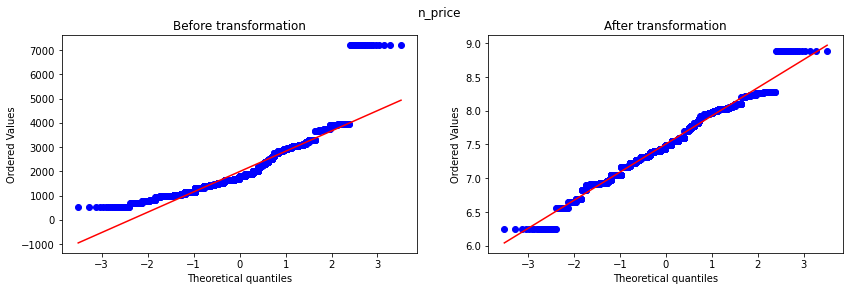

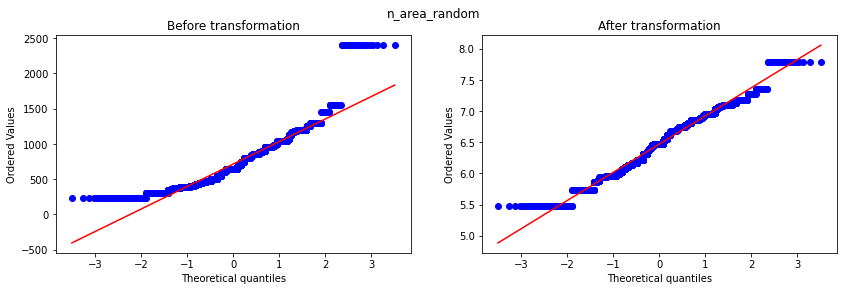

In [512]:
def log_trans(df):
    df_log = pd.DataFrame()
    for f in df.columns:
        df_log[f] = np.log(df[f])
    df_log.dropna(axis = 1, inplace = True)
    return df_log

new_df_log = pd.DataFrame()
new_df_log = log_trans(df)


for f in to_plot:
    
    plt.figure(figsize=(14,4))
    
    plt.subplot(1,2,1)

    plt.suptitle(f)
    stats.probplot(df_con[f], dist = 'norm', plot = pylab)
    plt.title("Before transformation")
    plt.subplot(1,2,2)

    stats.probplot(new_df_log[f], dist = 'norm', plot = pylab)
    plt.title("After transformation")
    plt.show()

Only log transformation appears to be promising for n_area_random and n_price features. 
Lets apply it to the df and check the correlation now


In [513]:
df['n_price_log'] = np.log(df['n_price'])
df['n_area_random_log'] = np.log(df['n_area_random'])

In [516]:
df

beach_availability  n_area_random  n_bathrooms  day_posted  n_price  \
0                      1          800.0            1          16     1950   
1                      0          480.0            1          19     1520   
2                      1          380.0            1          30     1500   
3                      0          400.0            1          24     1380   
4                      0          650.0            1          24     1025   
...                  ...            ...          ...         ...      ...   
3115                   0          650.0            1          23     1900   
3116                   1         1188.0            2          23     2895   
3117                   0         1000.0            5          16     1800   
3118                   1          750.0            5          23     2650   
3119                   1          460.0            1          21     1650   

      n_price_log  n_area_random_log  
0        7.575585           6.684612  
1        7.326466           6.173786  
2        7.313220           5.940171  
3        7.229839           5.991465  
4        6.932448           6.476972  
...           ...                ...  
3115     7.549609           6.476972  
3116     7.970740           7.080026  
3117     7.495542           6.907755  
3118     7.882315           6.620073  
3119     7.408531           6.131226  

[3120 rows x 7 columns]

In [520]:
df.columns

Index(['beach_availability', 'n_area_random', 'n_bathrooms', 'day_posted',
       'n_price', 'n_price_log', 'n_area_random_log'],
      dtype='object')

In [521]:
df_log = df[['beach_availability', 'n_bathrooms', 'day_posted', 'n_price_log', 'n_area_random_log']]

Text(0.5, 1.0, 'Log correlations')

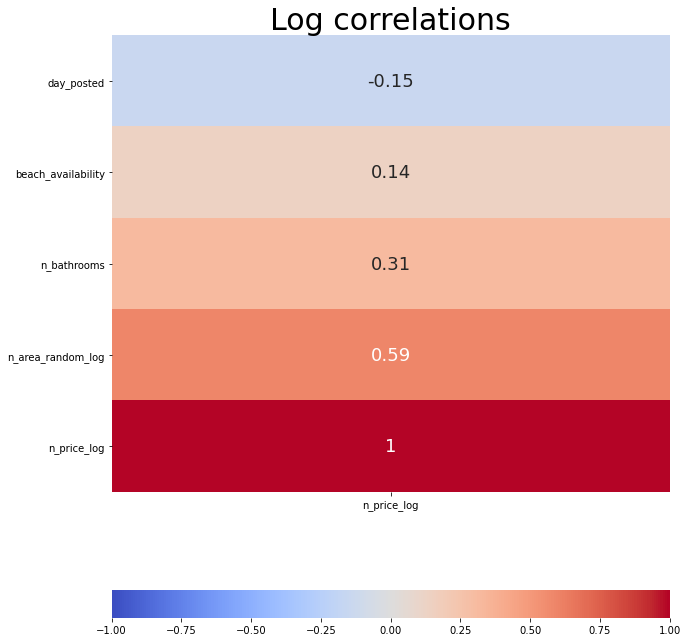

In [523]:
fig = plt.figure(figsize = (10,12))
#fig.suptitle('Comparison of the feature correlation done before and after feature engineering', fontsize = 30)
g = sns.heatmap(df_log.corr()[['n_price_log']].sort_values(by='n_price_log'), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1, annot_kws={"size": 18} , cbar_kws={"orientation": "horizontal"},
               xticklabels=True, yticklabels=True)

g.set_title('Log correlations', fontsize =30)

Modifyng both distributions (n_area and n_price) by log transformations did not help even decreased the initial (0.64) corr coefficient of n_area

In [524]:
df.columns

Index(['beach_availability', 'n_area_random', 'n_bathrooms', 'day_posted',
       'n_price', 'n_price_log', 'n_area_random_log'],
      dtype='object')

Lets see if we just modify only n_area

In [526]:
df_area = df[['beach_availability', 'n_bathrooms', 'day_posted',
       'n_price',  'n_area_random_log']]

Text(0.5, 1.0, 'Log correlations')

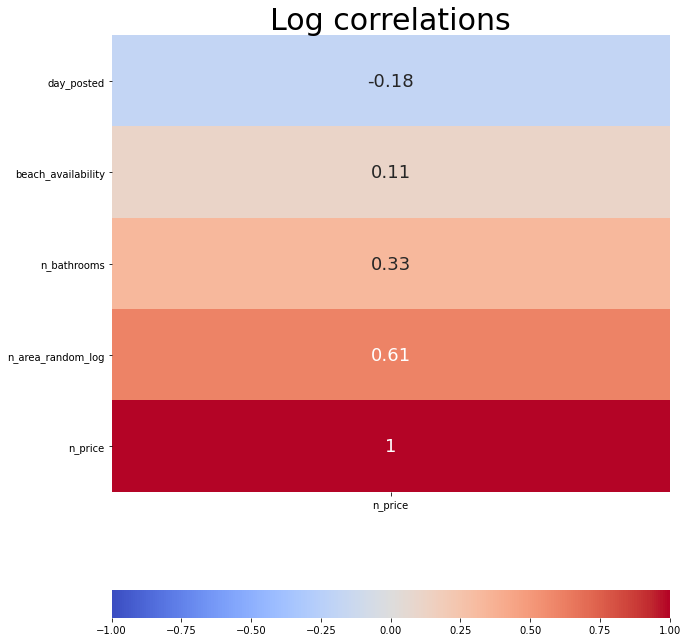

In [527]:
fig = plt.figure(figsize = (10,12))
#fig.suptitle('Comparison of the feature correlation done before and after feature engineering', fontsize = 30)
g = sns.heatmap(df_area.corr()[['n_price']].sort_values(by='n_price'), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1, annot_kws={"size": 18} , cbar_kws={"orientation": "horizontal"},
               xticklabels=True, yticklabels=True)

g.set_title('Log correlations', fontsize =30)

It did really help either, so we stay with the original distributions

In [530]:
df.columns

Index(['beach_availability', 'n_area_random', 'n_bathrooms', 'day_posted',
       'n_price', 'n_price_log', 'n_area_random_log'],
      dtype='object')

In [531]:
df = df[['beach_availability', 'n_area_random', 'n_bathrooms', 'day_posted',
       'n_price']]

Text(0.5, 1.0, 'Log correlations')

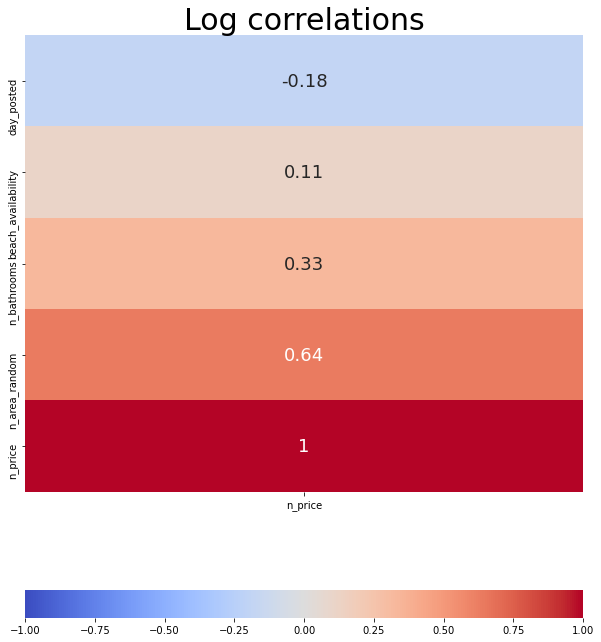

In [532]:
fig = plt.figure(figsize = (10,12))
#fig.suptitle('Comparison of the feature correlation done before and after feature engineering', fontsize = 30)
g = sns.heatmap(df.corr()[['n_price']].sort_values(by='n_price'), 
                    annot=True, 
                    cmap='coolwarm', 
                    vmin=-1,
                    vmax=1, annot_kws={"size": 18} , cbar_kws={"orientation": "horizontal"},
               xticklabels=True, yticklabels=True)

g.set_title('Log correlations', fontsize =30)

# Outliers imputation 

For regression analysis it is necessary to scale features because non-scaled features will result in biased output for models as linear regression and KNN. Tree based methods do not suffer from outliers. I plan not to delete outliers as we may lose some key data, I however will impute the outliers by the lower and upper extremes of the distribition that features have

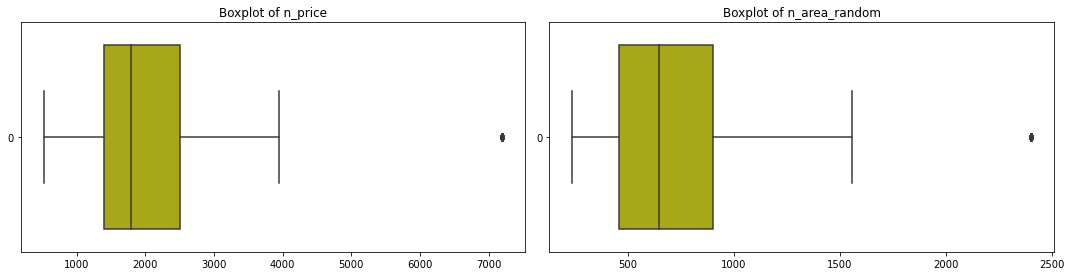

In [533]:
#Frequency of each category separated by label
plt.figure(figsize=[15,18])
feafures = ['n_price', 'n_area_random']
#take all columns except the target Selling_Price
n=1
for f in feafures:
    plt.subplot(5,2,n)
    sns.boxplot(data = df[f], orient='h', color = 'y')
    plt.title("Boxplot of {}".format(f))
    n=n+1
plt.tight_layout()
plt.show()

In [536]:
def outliers_imputation(df, cols):
    """
    calculating the Interquartile range of a feature
    """
    for col in cols:
        
        IQR=df[col].quantile(0.75)-df[col].quantile(0.25)

        #calculating the borders of the normal distribution of Chance_of_Admit
        lower_bridge=df[col].quantile(0.25)-(IQR*1.5)
        upper_bridge=df[col].quantile(0.75)+(IQR*1.5)

        #Inpute the outliers with the min values that are present for the normal distribution of Chance_of_Admit
        df.loc[df[col]<=lower_bridge, col]=lower_bridge
        df.loc[df[col]>=upper_bridge, col]=upper_bridge
    
    return df

In [537]:
# lets impute outliers that are on the left side of cost_square_meter_mode_log
cols = ['n_price', 'n_area_random']
df = outliers_imputation(df, cols)

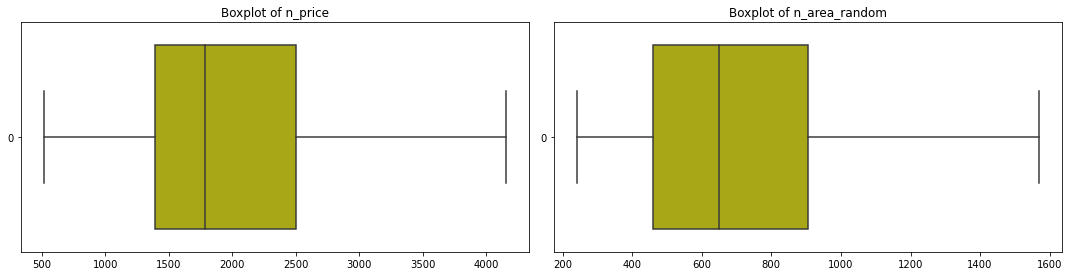

In [538]:
#Frequency of each category separated by label
plt.figure(figsize=[15,18])
feafures = ['n_price', 'n_area_random']
#take all columns except the target Selling_Price
n=1
for f in feafures:
    plt.subplot(5,2,n)
    sns.boxplot(data = df[f], orient='h', color = 'y')
    plt.title("Boxplot of {}".format(f))
    n=n+1
plt.tight_layout()
plt.show()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FF8ABF5700>,
      dtype=object)

<Figure size 1008x288 with 0 Axes>

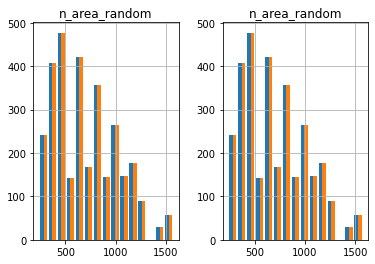

In [539]:
plt.figure(figsize=(14,4))

df[['n_area_random', 'n_area_random']].hist(bins = 15)

In [540]:
df.head()

beach_availability  n_area_random  n_bathrooms  day_posted  n_price
0                   1          800.0            1          16   1950.0
1                   0          480.0            1          19   1520.0
2                   1          380.0            1          30   1500.0
3                   0          400.0            1          24   1380.0
4                   0          650.0            1          24   1025.0

# Feature Scaling 

In [543]:
df.dtypes

beach_availability      int32
n_area_random         float64
n_bathrooms             int32
day_posted              int32
n_price               float64
dtype: object

In [546]:
def visualizing_scaled_features(df):
    """
    visualizing the scaled features
    """
    
    # select numeric columns
    df_numeric = df.select_dtypes(include=[np.float])
    numeric_cols = df_numeric.columns.values
    numeric_cols
    
    from sklearn import preprocessing
    for col in numeric_cols:

        np.random.seed(1)
        scaler = preprocessing.StandardScaler()
        scaled_df_2 = scaler.fit_transform(df[col].values.reshape(-1, 1))
        scaled_df = pd.DataFrame(scaled_df_2, columns=[col])
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 2))
        ax1.set_title('Before Scaling')
        sns.kdeplot(df[col], ax=ax1)

        ax2.set_title('After Standard Scaler')
        sns.kdeplot(scaled_df[col], ax=ax2, color = 'y')
        plt.show()

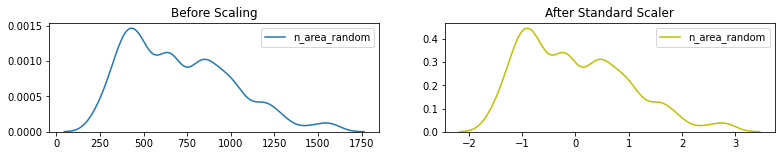

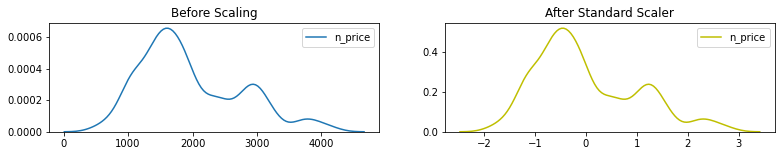

In [547]:
visualizing_scaled_features(df)

In [548]:
df.head()

beach_availability  n_area_random  n_bathrooms  day_posted  n_price
0                   1          800.0            1          16   1950.0
1                   0          480.0            1          19   1520.0
2                   1          380.0            1          30   1500.0
3                   0          400.0            1          24   1380.0
4                   0          650.0            1          24   1025.0

In [549]:
# preparing data for the train_test_split
X = df.iloc[:,:-1]
Y = df.iloc[:, -1]

In [550]:
X

beach_availability  n_area_random  n_bathrooms  day_posted
0                      1          800.0            1          16
1                      0          480.0            1          19
2                      1          380.0            1          30
3                      0          400.0            1          24
4                      0          650.0            1          24
...                  ...            ...          ...         ...
3115                   0          650.0            1          23
3116                   1         1188.0            2          23
3117                   0         1000.0            5          16
3118                   1          750.0            5          23
3119                   1          460.0            1          21

[3120 rows x 4 columns]

In [551]:
Y

0       1950.0
1       1520.0
2       1500.0
3       1380.0
4       1025.0
         ...  
3115    1900.0
3116    2895.0
3117    1800.0
3118    2650.0
3119    1650.0
Name: n_price, Length: 3120, dtype: float64

In [552]:
# splitting data into test and train splits
from sklearn.model_selection import train_test_split

# split data into test (20%) and train (80%) parts
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (2496, 4)
x test:  (624, 4)
y train:  (2496,)
y test:  (624,)


In [553]:
# features scaling
sc = StandardScaler()
X_train_st = sc.fit_transform(X_train)
X_test_st = sc.transform(X_test)

print('X_train: ', X_train_st)
print()
print('X_test: ', X_test_st)

# Model selection 

In [555]:
# creating a dictionary of the models (estimators) 
estimators = {
    'Linear Regression': [LinearRegression()],
    'Lasso' :[Lasso()],
    'Ridge' :[Ridge()],
    'KNN' :[KNeighborsRegressor()],
    'Decision Tree' :[DecisionTreeRegressor()],
    'Ransom Forest' :[RandomForestRegressor()],
    'XG Boost': [XGBRegressor()],
}

# writing a function to fit models above to the train dataset
def mfit(estimators, X_train_st, y_train):
    for m in estimators:
        estimators[m][0].fit(X_train_st, y_train)
        print(m+' fitted')

mfit(estimators, X_train_st, y_train)

Linear Regression fitted
Lasso fitted
Ridge fitted
KNN fitted
Decision Tree fitted
Ransom Forest fitted
XG Boost fitted


In [556]:
import sklearn.metrics as metrics

# applying the fitted models to the test dataset
def mpredict(estimators, X_test_st, y_test):
    outcome = dict()
    for m in estimators:
        y_pred = estimators[m][0].predict(X_test_st)
        outcome[m] = [round(metrics.r2_score(y_test, y_pred), 2), 
                      metrics.mean_absolute_error(y_test, y_pred),
                     
                     metrics.mean_squared_error(y_test, y_pred),
                     np.sqrt(metrics.mean_squared_error(y_test, y_pred))]
    return outcome

outcome = mpredict(estimators, X_test_st, y_test)

In [559]:
#printing the regression errors as metrics for the model evaluation
for m in outcome:
    print('------------------------'+m+'------------------------')
    print('R2 score', round(outcome[m][0],2))
    print('MAE', round(outcome[m][1],2))
    print('MSE', round(outcome[m][2],2))
    print('RMSE', round(outcome[m][3],2))

------------------------Linear Regression------------------------
R2 score 0.47
MAE 444.41
MSE 360157.32
RMSE 600.13
------------------------Lasso------------------------
R2 score 0.47
MAE 444.42
MSE 360281.66
RMSE 600.23
------------------------Ridge------------------------
R2 score 0.47
MAE 444.43
MSE 360190.35
RMSE 600.16
------------------------KNN------------------------
R2 score 0.83
MAE 91.09
MSE 114357.19
RMSE 338.17
------------------------Decision Tree------------------------
R2 score 0.81
MAE 92.16
MSE 131610.31
RMSE 362.78
------------------------Ransom Forest------------------------
R2 score 0.84
MAE 90.47
MSE 109273.58
RMSE 330.57
------------------------XG Boost------------------------
R2 score 0.83
MAE 89.51
MSE 117944.08
RMSE 343.43


Evaluate the model, what kind of the metrics we will use here?
Random Forest has the highest R2 score and the lowest MAE, MSE, RMSE errors.



# Hyperparameter tuning 



Randomized search CV

As Random Forest so far is the best model for the regression task, lets try to improve the R2 factor and reduce the errors.

In [558]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)

In [560]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [561]:
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [562]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_st, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [563]:
# checking best hyperparameters
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None,
 'bootstrap': True}

In [569]:
def evaluate(model, X_test_st, y_test):
    """
    checking the model accuracy
    """
    predictions = model.predict(X_test_st)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [572]:
# checking the model accuracy

base_model = RandomForestRegressor(n_estimators= 10, random_state = 42)

base_model.fit(X_train_st, y_train)
base_accuracy = evaluate(base_model, X_test_st, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test_st, y_test)

Model Performance
Average Error: 89.0079 degrees.
Accuracy = 92.77%.
Model Performance
Average Error: 86.3874 degrees.
Accuracy = 92.90%.


In [573]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.13%.


Check it for Random Forest regressor

In [576]:
# for Random Forest with the best hyperparameters
rf = RandomForestRegressor(n_estimators= 1600,min_samples_split= 10,min_samples_leaf= 1,
                           max_features= 'sqrt',max_depth= None, bootstrap= True, random_state = 42)

# fir train data to the model
rf.fit(X_train_st, y_train)

# find predictions
predictions = rf.predict(X_test_st)

In [577]:
from sklearn.model_selection import cross_val_score

#calculate cross validated R2
R2 = cross_val_score(rf, X=X_train_st, y=y_train,cv=10, scoring='r2').mean()  

#display adjusted R-squared
#calculate Adj R2
n= len(X_train)
p = len(X_train.columns)
adj_R2 = 1- ((1-R2) * (n-1)/(n-p-1))

In [578]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print("R2 score =", round(metrics.r2_score(y_test, predictions), 2))
print("adjR2 score =", round(adj_R2, 2))

MAE: 86.42512622967598
MSE: 94164.48185291178
RMSE: 306.8623174208781
R2 score = 0.86
adjR2 score = 0.89


Comparing to the Random Forest Regressor without hyperparameters tuning, we can clearly see that our model has significantly improved:
R2 score increased by 0.02
MAE and MSE decreased, but RMSE increased


What metrics do we plan to use for the model evaluation?
Do outliers play a decisive role here?

In this regression case, I would opt for the MAE error, because the price is mostly proportional to the predictors. For example, as n_area increases by certain number, the price increases as well to some certain number. Regarding the alternative metric: RMSE metric could be very helpful in case of clinical trial or drug dosage analysis, where the change in dosage does not have this kind of proportionality and effect become evident once the critical border would be passed. Here we have not detected the exponential and other correlation. Even for the linear model we know that with 0.64 coeff (n_area vs n_price) as n_area increases by 1 , n_price increases by 0.64.

88% of the n_price variance can be explained by 4 features ('beach_availability', 'n_area_random', 'n_bathrooms', 'day_diff')

Lets see the distribution between the predictions we have made and the actual distribution of the true n_price variables obtained from the test dataset

In [579]:
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 11.7,3.27

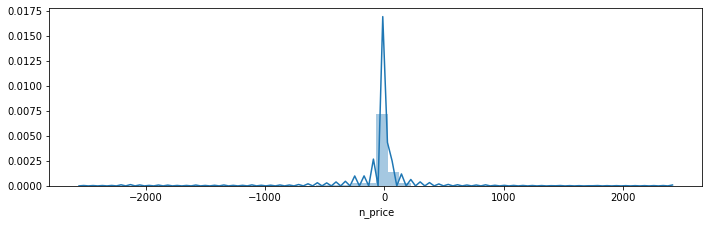

In [580]:
import seaborn as sns
sns.distplot(y_test-predictions)

Even though the predicted data resulted in some outliers, overall distribution look satisfactory.

Now we can take a look at how the Random Forest Regressor works to get us to the right answer. We can visualize the whole process of constructing a decision tree from the beginning.

In [581]:
def plot_a_decision_tree():
    """
    get one of the 1600 decision trees to visualize model
    """

    # Fit the random search model
    model = rf.fit(X_train_st, y_train)


    # get a tree
    estimator = rf.estimators_[5]

    from sklearn.tree import export_graphviz
    # Export as dot file
    export_graphviz(estimator, out_file='tree.dot', 
                    feature_names = df.columns[:-1],
                    class_names = df.columns[-1],
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    # convert data to png image
    import pydot
    (graph,) = pydot.graph_from_dot_file('tree.dot')
    graph.write_png('somefile.png')

    # Display in jupyter notebook
    from IPython.display import Image
    
    return Image(filename = 'somefile.png')

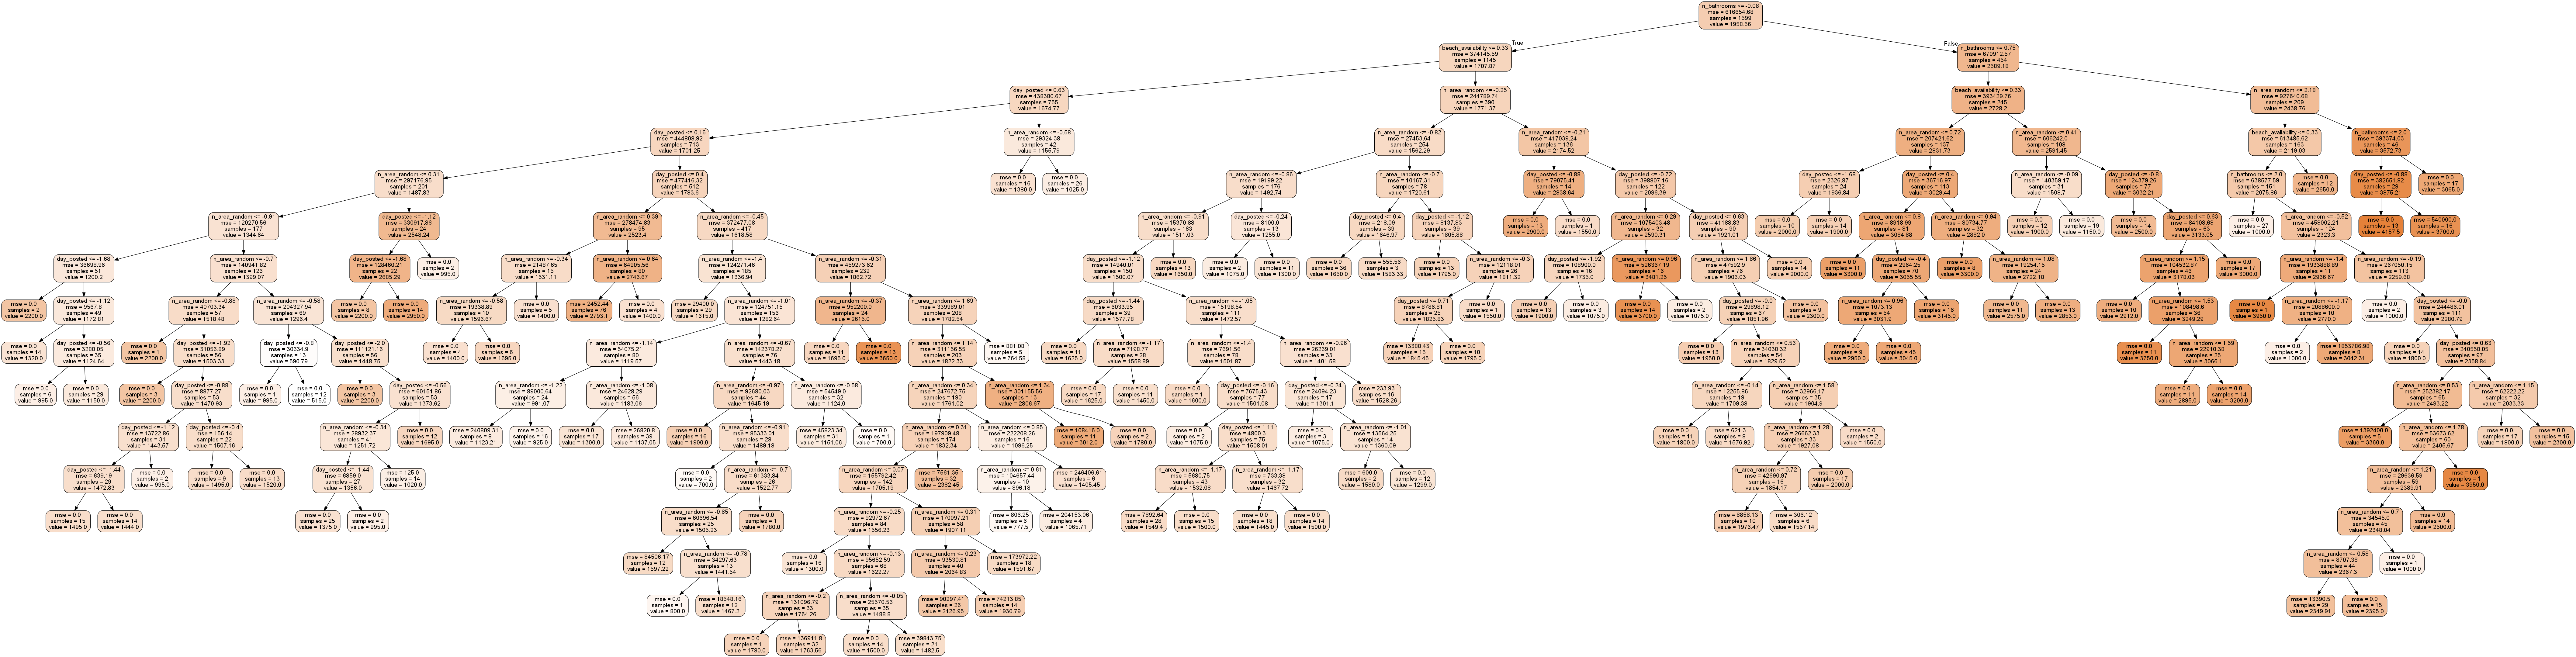

In [582]:
plot_a_decision_tree()

# Model_Evaluation
There are four key assumptions that need to be tested for a linear regression model:

1. Linearity: The expected value of the dependent variable is a linear function of each independent variable, holding the others fixed (note this does not restrict you to use a nonlinear transformation of the independent variables i.e. you can still model f(x) = ax² + bx + c, using both x² and x as predicting variables.

2. Independence: The errors (residuals of the fitted model) are independent of each other.

3. Homoscedasticity (constant variance): The variance of the errors is constant with respect to the predicting variables or the response.

4. Normality: The errors are generated from a Normal distribution (of unknown mean and variance, which can be estimated from the data). Note, this is not a necessary condition to perform linear regression unlike the top three above. However, without this assumption being satisfied, you cannot calculate the so-called ‘confidence’ or ‘prediction’ intervals easily as the well-known analytical expressions corresponding to Gaussian distribution cannot be used. Ref 

In [583]:
df.columns

Index(['beach_availability', 'n_area_random', 'n_bathrooms', 'day_posted',
       'n_price'],
      dtype='object')

In [584]:
import statsmodels.formula.api as sm
model=sm.ols(formula = 'n_price ~ beach_availability + n_area_random + n_bathrooms + day_posted', 
             data=df)
fitted = model.fit()
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                n_price   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     642.2
Date:                Thu, 02 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:34:41   Log-Likelihood:                -24309.
No. Observations:                3120   AIC:                         4.863e+04
Df Residuals:                    3115   BIC:                         4.866e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            972.6089     43

Linear model showed only 0.45 coefficient, which is kind of low comparing to the one obtained with the Random Forest (0.88)

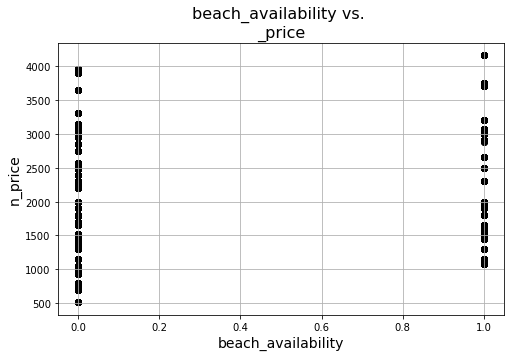

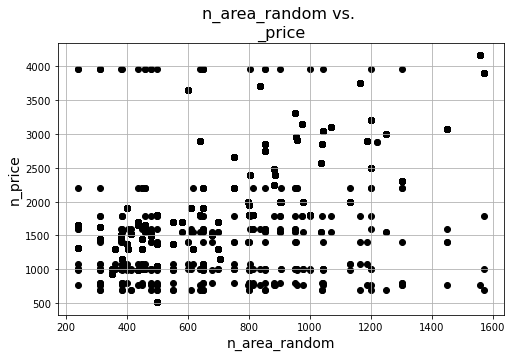

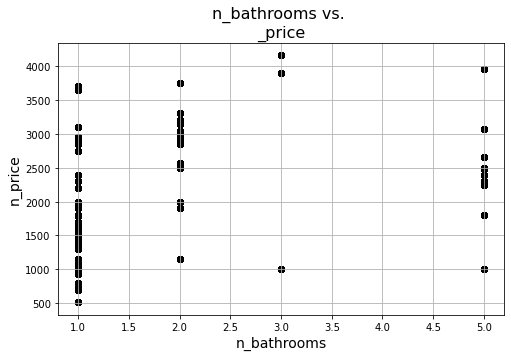

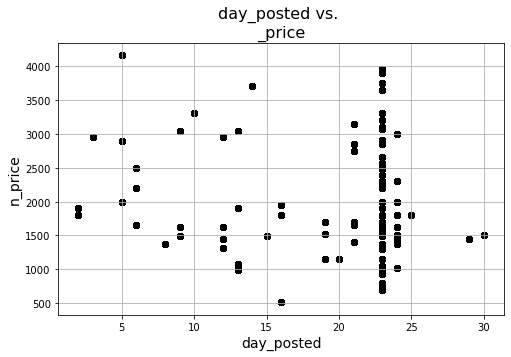

In [585]:
#Checking for the linearity 
for c in df.drop('n_price', axis = 1):
    plt.figure(figsize=(8,5))
    plt.title("{} vs. \n_price".format(c),fontsize=16)
    plt.scatter(x=df[c],y=df['n_price'],color='black',edgecolor='k')
    plt.grid(True)
    plt.xlabel(c,fontsize=14)
    plt.ylabel('n_price',fontsize=14)

    plt.show()

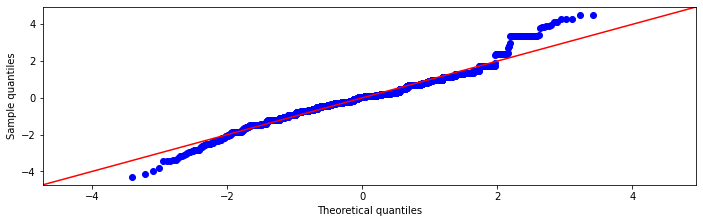

In [586]:
#Checking for Normality
from statsmodels.graphics.gofplots import qqplot
fig=qqplot(fitted.resid_pearson,line='45',fit = 'True')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Sample quantiles')
plt.show()

The normality assumption may not hold


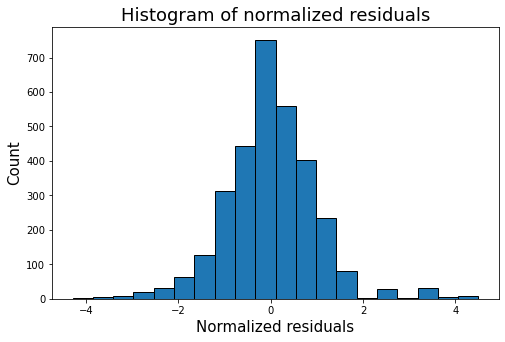

In [587]:
#Checking for Normality
from scipy.stats import shapiro
_,p=shapiro(fitted.resid)
if p>0.05:
    print("The residuals seem to come from Gaussian process")
else:
    print("The normality assumption may not hold")
    
plt.figure(figsize=(8,5))
plt.hist(fitted.resid_pearson,bins=20,edgecolor='k')
plt.ylabel('Count',fontsize=15)
plt.xlabel('Normalized residuals',fontsize=15)
plt.title("Histogram of normalized residuals",fontsize=18)
plt.show()

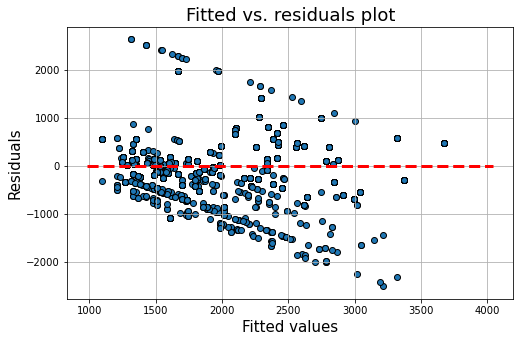

In [588]:
#Checking for Homoscedasticity
plt.figure(figsize=(8,5))
p=plt.scatter(x=fitted.fittedvalues,y=fitted.resid,edgecolor='k')
xmin=min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
plt.hlines(y=0,xmin=xmin*0.9,xmax=xmax*1.1,color='red',linestyle='--',lw=3)
plt.xlabel("Fitted values",fontsize=15)
plt.ylabel("Residuals",fontsize=15)
plt.title("Fitted vs. residuals plot",fontsize=18)
plt.grid(True)
plt.show()

In [589]:
#Autocorrelation
from statsmodels.stats.stattools import durbin_watson
durbinWatson = durbin_watson(fitted.resid)
print(durbinWatson)

1.7127440098162605


# Conclusion

It looks like the linear regression model did not pass required tests, thus must be discarded. We however will continue with the model obtained the Random Forest Regressor